# Ressources

In [1]:
import pandas as pd 
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
import sklearn.metrics
from xgboost import XGBRegressor
from sklearn import svm
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# supprime les FutureWarnings dû à l'utilisation de pandas (.append/.drop)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')


# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"


# Import data

In [2]:
df = pd.read_csv('data_final.csv')
df_energystar = pd.read_csv('data_energystar.csv')
df

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,LargestPropertyUseTypeGFA_avg,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg,PropertyGFABuilding(s)_%,PropertyGFAParking_%,Dureedevie
0,1,NonResidential,1.0,12.0,47.61220,-122.33799,Hotel/Senior Care/Housing,88434.0,0.0,88434.0,88434.0,7.103895e+06,249.705,1.00,0.00,89
1,2,NonResidential,1.0,11.0,47.61317,-122.33393,Hotel/Senior Care/Housing,103566.0,15064.0,88502.0,83880.0,8.371084e+06,279.685,0.85,0.15,20
2,3,NonResidential,1.0,41.0,47.61393,-122.33810,Hotel/Senior Care/Housing,959050.0,98359.0,860691.0,756868.0,7.285884e+07,2075.380,0.90,0.10,47
3,5,NonResidential,1.0,10.0,47.61412,-122.33664,Hotel/Senior Care/Housing,61320.0,0.0,61320.0,61320.0,1.751195e+07,1111.385,1.00,0.00,90
4,8,NonResidential,1.0,18.0,47.61375,-122.34047,Hotel/Senior Care/Housing,147735.0,37230.0,110505.0,123445.0,1.450085e+07,506.355,0.75,0.25,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,50222,Nonresidential COS,1.0,1.0,47.56722,-122.31154,Office,12294.0,0.0,12294.0,12294.0,8.497457e+05,20.940,1.00,0.00,26
1680,50223,Nonresidential COS,1.0,1.0,47.59625,-122.32283,Loisirs,16000.0,0.0,16000.0,16000.0,9.502762e+05,32.170,1.00,0.00,12
1681,50224,Nonresidential COS,1.0,1.0,47.63644,-122.35784,Loisirs,13157.0,0.0,13157.0,7583.0,5.765898e+06,223.540,1.00,0.00,42
1682,50225,Nonresidential COS,1.0,1.0,47.52832,-122.32431,Loisirs,14101.0,0.0,14101.0,6601.0,7.194712e+05,22.110,1.00,0.00,27


# Fonctions


## Fonctions Filtrage

In [3]:
def df_filtre_categorical(df):
    categorical_columns = df.select_dtypes(['object']).columns
    categorical_columns
    # LargestPropertyUseType donne assez d'informations pour notre modèle.
    categorical_columns = categorical_columns.drop(['BuildingType'])
    return categorical_columns

def df_filtre_numerical(df):
    numerical_columns = df.select_dtypes(['int64', 'float64']).columns

    numerical_columns = numerical_columns.drop('OSEBuildingID')  # cette variable n'influence pas la consommation
    numerical_columns = numerical_columns.drop(['Longitude', 'Latitude'])  # tout se déroule à Seattle.. pas pertinent
    numerical_columns = numerical_columns.drop(['PropertyGFAParking_avg', 'PropertyGFABuilding(s)_avg']) # si on prend les colonnes %
    numerical_columns = numerical_columns.drop(['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg'])  # variables Y
    return numerical_columns

## Fonctions Encodage

In [4]:
# https://datagy.io/sklearn-one-hot-encode/

def df_encodage_categorie(df, categorical_columns):

    ohe = OneHotEncoder(sparse=False)  # Will return sparse matrix if set True else will return an array.
    cat_enc = ohe.fit_transform(df[categorical_columns])

    df_ohe = pd.DataFrame(cat_enc)
    return ohe, df_ohe

def df_scaling_numeric(df, numerical_columns):
    ss = StandardScaler()
    df[numerical_columns] = ss.fit_transform(df[numerical_columns])

    return df[numerical_columns]



## Fonctions Evaluation des modèles

In [5]:
def training_model(df_train, Y_target, test_size=0.33, random_state=42):
    
    # on peut essayer de trouver les paramètres optimaux avec GridSearchSV. Toutefois, étant donné que c'est la première fois, on va privilégier une validation_curve pour que je les trouve moi-même !
    
    # Src : https://www.youtube.com/watch?v=w_bLGK4Pteo (cross validation score / validation_curve)
    
    
    # listes qui vont servir à créer un dataframe
    score_training_liste = []
    cross_liste = []
    mae_liste = []
    mse_liste = []
    rmse_liste = []
      
    
    # la variable visée
    
    X_train, X_test, y_train, y_test = train_test_split(df_train,
                                                    Y_target,
                                                    test_size=test_size,
                                                    random_state=random_state) 
    
    # les algos qu'on va tester
    algos = {
    'LinearRegression' : LinearRegression(),
    'Lasso' : Lasso(tol=0.5),
    'Ridge' : Ridge(),
    'ElasticNet' : ElasticNet(),
    'RandomForestRegressor' : RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=-1),
    'SVR' : svm.SVR(cache_size=7000, max_iter=1000)
}
    # les hyper paramètres qu'on va faire varier pour trouver le meilleur score
    hyperparametres = {
    'LinearRegression' : ['n_jobs', np.arange(1,50)],  # The number of jobs to use for the computation
    'Lasso' : ['alpha', np.arange(0.01,1, 0.05)],
    'Ridge' : ['alpha', np.arange(0.01,1, 0.05)],
    'ElasticNet' : ['alpha', np.arange(0.01, 1, 0.05)],
    'RandomForestRegressor' : ['n_estimators', [20,50,100,500,1000,2000]],  #nombre d'arbres dans la foret
    'XGBRegressor': ['n_estimators', [20,50,100,500,1000,2000]], # nombre d'arbres dans la foret
    'SVR' : ['gamma', [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]]
}
    # on teste
    for algo_name, algo in algos.items():
        model = algo.fit(X_train, y_train)
        score_entrainement = model.score(X_test, y_test)
        cross_validation = cross_val_score(algo, X_train, y_train, cv=5).mean() # permet de découper le trainset en 5 parties et de tester. On fait ensuite la moyenne des notes :)
        train_score, val_score = validation_curve(algo, X_train, y_train, param_name=hyperparametres[algo_name][0], param_range=hyperparametres[algo_name][1], cv=5)
        predict = model.predict(X_test)
        
        
    #Pour évaluer un modèle de régression, on peut calculer la distance entre valeurs prédites et vraies valeurs. Cela nous donne :
    #la somme des carrés des résidus (RSS) ;
    # la moyenne de cette somme (MSE) ;
    # la racine carrée de cette moyenne (RMSE).
        mae = sklearn.metrics.mean_absolute_error(y_test, predict) # Mean absolute error regression loss.
        mse = np.square(np.subtract(y_test,predict)).mean() 
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, predict)) # Mean squared error regression loss.

        # on ajoute les résultats dans les listes pour le dataframe
        score_training_liste.append(score_entrainement) # note : r2_score donne le mm resultat
        cross_liste.append(cross_validation)
        mae_liste.append(mae)
        mse_liste.append(mse)
        rmse_liste.append(rmse)
        
        # on affiche les résultats

        
        print(algo_name)
        print('Score entrainement: ' + str(score_entrainement))
        print('Cross: ' + str(cross_validation))

        '''
        The mean absolute error measures the average differences between predicted values and actual values
        Unlike the mean squared error (MSE), the MAE calculates the error on the same scale as the data. This means it’s easier to interpret.
        The MAE doesn’t square the differences and is less susceptible to outliers
        Both values are negatively-oriented. This means that, while both range from 0 to infinity, lower values are better.
        For example, in our earlier example of a MAE of 10, if the values ranged from 10,000 to 100,000 a MAE of 10 would be great. However, if the values ranged from 0 through 20, a MAE would be terrible.
        Src : https://datagy.io/mae-python/
        '''
        
        print('MAE : ' + str(mae))
        
        # So, MSE is a risk function that helps us determine the average squared difference between the predicted and the actual value of a feature or variable.
        
        print('MSE : ' + str(mse))
        
        '''
        RMSE is an acronym for Root Mean Square Error, which is the square root of value obtained from Mean Square Error function.

        Using RMSE, we can easily plot a difference between the estimated and actual values of a parameter of the model.

        By this, we can clearly judge the efficiency of the model.

        Usually, a RMSE score of less than 180 is considered a good score for a moderately or well working algorithm. 
        In case, the RMSE value exceeds 180, we need to perform feature selection and hyper parameter tuning on the parameters of the model.
        '''
        
        print('RMSE : ' + str(rmse))
        
        
        # Graphique des résultats
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        ax1.scatter(y_test, predict, c='coral')
        ax1.set_title(f'Prediction : {Y_target.name} avec {algo_name}')
        ax1.set_xlabel("Vraies valeurs", size = 12)
        ax1.set_ylabel("Valeurs prédictes", size = 12)
        
        ax2.plot(hyperparametres[algo_name][1], val_score.mean(axis=1), label="validation")
        ax2.plot(hyperparametres[algo_name][1], train_score.mean(axis=1), label="train")
        ax2.set_title(f'Validation curve ({algo_name})')
        ax2.set_xlabel(hyperparametres[algo_name][0], size = 12)
        ax2.set_ylabel("score", size = 12)
        ax2.legend()
        
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

        plt.show()
        
        print('--------')
        
    # le dataframe
        
    df_liste = pd.DataFrame([algos.keys(), score_training_liste, cross_liste, mae_liste, mse_liste, rmse_liste])
    df_liste = df_liste.transpose()
    df_liste = df_liste.rename(columns={0:'Model', 1:'Score training', 2: 'Cross Validation', 3: 'MAE', 4:'MSE', 5:'RMSE'})
        
    return df_liste



def predict_optuna(df, var_target, hyperparametres):
    
    
    X_train, X_test, y_train, y_test = train_test_split(df,
                                                        var_target,
                                                        test_size=0.33,
                                                        random_state=0)
    classifier = hyperparametres.params['classifier']
    del hyperparametres.params['classifier']
    
    if classifier == 'XGBRegressor':
        model = XGBRegressor(**hyperparametres.params)
    elif classifier == 'SVR':
        model = svm.SVR(**hyperparametres.params)
    elif classifier == 'RandomForest':
        model = RandomForestRegressor(**hyperparametres.params)
    model.fit(X_train, y_train)
    
    print(model.score(X_test, y_test))
    print(cross_val_score(model, X_train, y_train, cv=5).mean())
    
    return classifier, model

## Fonction Feature Importance

In [6]:
def feature_importance(model, classifier, index):
    df_features = pd.DataFrame(model.feature_importances_, index=index)
    fig = px.histogram(x=df_features[0], y=df_features.index, color=df_features.index, title="Features importance " + str(classifier), width=1600, height=1400).update_yaxes(categoryorder="total ascending")
    fig.update_layout(showlegend=False)
    return fig

# Prediction sans EnergyStarScore
<span style="color: #00B0F0">Variables à prédire : TotalGHGEmissions et SiteEnergyUse(kBtu)</span>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1684 non-null   int64  
 1   BuildingType                   1684 non-null   object 
 2   NumberofBuildings              1684 non-null   float64
 3   NumberofFloors                 1684 non-null   float64
 4   Latitude                       1684 non-null   float64
 5   Longitude                      1684 non-null   float64
 6   LargestPropertyUseType         1684 non-null   object 
 7   PropertyGFATotal_avg           1684 non-null   float64
 8   PropertyGFAParking_avg         1684 non-null   float64
 9   PropertyGFABuilding(s)_avg     1684 non-null   float64
 10  LargestPropertyUseTypeGFA_avg  1684 non-null   float64
 11  SiteEnergyUse(kBtu)_avg        1684 non-null   float64
 12  TotalGHGEmissions_avg          1684 non-null   f

## Séparation des types de variables

Pour séparer les variables ... et comme c'est la première fois, je vais le faire à la main.
Néanmoins, pour les prochains, il peut être utile d'utiliser make_pipeline et make_column_transformer (Tuto here : https://www.youtube.com/watch?v=41mnga4ptso)

In [8]:
categorical_columns = df_filtre_categorical(df)

In [9]:
numerical_columns = df_filtre_numerical(df)
numerical_columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal_avg',
       'LargestPropertyUseTypeGFA_avg', 'PropertyGFABuilding(s)_%',
       'PropertyGFAParking_%', 'Dureedevie'],
      dtype='object')

## Variables object

In this tutorial, you’ll learn how to use the OneHotEncoder class in Scikit-Learn to one hot encode your categorical data in sklearn. One-hot encoding is a process by which categorical data (such as nominal data) are converted into numerical features of a dataset. This is often a required preprocessing step since machine learning models require numerical data.

In [10]:
ohe, df_ohe = df_encodage_categorie(df, categorical_columns)
df_ohe

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# # On réinitialise l'index pour que ça colle avec le df_ohe
df.reset_index(drop=True, inplace=True)

In [12]:
df[df_ohe.columns.values] = df_ohe
df

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,19,20,21,22,23,24,25,26,27,28
0,1,NonResidential,1.0,12.0,47.61220,-122.33799,Hotel/Senior Care/Housing,88434.0,0.0,88434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NonResidential,1.0,11.0,47.61317,-122.33393,Hotel/Senior Care/Housing,103566.0,15064.0,88502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NonResidential,1.0,41.0,47.61393,-122.33810,Hotel/Senior Care/Housing,959050.0,98359.0,860691.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,NonResidential,1.0,10.0,47.61412,-122.33664,Hotel/Senior Care/Housing,61320.0,0.0,61320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,NonResidential,1.0,18.0,47.61375,-122.34047,Hotel/Senior Care/Housing,147735.0,37230.0,110505.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,50222,Nonresidential COS,1.0,1.0,47.56722,-122.31154,Office,12294.0,0.0,12294.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,50223,Nonresidential COS,1.0,1.0,47.59625,-122.32283,Loisirs,16000.0,0.0,16000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,50224,Nonresidential COS,1.0,1.0,47.63644,-122.35784,Loisirs,13157.0,0.0,13157.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,50225,Nonresidential COS,1.0,1.0,47.52832,-122.32431,Loisirs,14101.0,0.0,14101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Variables numériques

In [13]:
df[numerical_columns] = df_scaling_numeric(df, numerical_columns)
df

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,19,20,21,22,23,24,25,26,27,28
0,1,NonResidential,-0.06895,1.206184,47.61220,-122.33799,Hotel/Senior Care/Housing,-0.102797,0.0,88434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NonResidential,-0.06895,1.053243,47.61317,-122.33393,Hotel/Senior Care/Housing,-0.051720,15064.0,88502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NonResidential,-0.06895,5.641483,47.61393,-122.33810,Hotel/Senior Care/Housing,2.835926,98359.0,860691.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,NonResidential,-0.06895,0.900301,47.61412,-122.33664,Hotel/Senior Care/Housing,-0.194319,0.0,61320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,NonResidential,-0.06895,2.123832,47.61375,-122.34047,Hotel/Senior Care/Housing,0.097370,37230.0,110505.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,50222,Nonresidential COS,-0.06895,-0.476171,47.56722,-122.31154,Office,-0.359804,0.0,12294.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,50223,Nonresidential COS,-0.06895,-0.476171,47.59625,-122.32283,Loisirs,-0.347295,0.0,16000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,50224,Nonresidential COS,-0.06895,-0.476171,47.63644,-122.35784,Loisirs,-0.356891,0.0,13157.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1682,50225,Nonresidential COS,-0.06895,-0.476171,47.52832,-122.32431,Loisirs,-0.353705,0.0,14101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Variables Y

In [14]:
Y = ['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']
Y = df[Y]
Y

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,7.103895e+06,249.705
1,8.371084e+06,279.685
2,7.285884e+07,2075.380
3,1.751195e+07,1111.385
4,1.450085e+07,506.355
...,...,...
1679,8.497457e+05,20.940
1680,9.502762e+05,32.170
1681,5.765898e+06,223.540
1682,7.194712e+05,22.110


### Vérification de la distribution...

In [15]:
fig = px.histogram(Y)
fig.show()

<span style="color: #FF7F00">La distribution n'est pas normale. On va donc appliquer un log pour la rendre plus normale, et l'aplatir</span>



### Correction de la distribution...

In [16]:
Y = np.log(1+Y)
df[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']] = np.log(df[['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']]) # pour s'en souvenir dans notre df
Y

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,15.776154,5.524277
1,15.940294,5.637233
2,18.104034,7.638381
3,16.678394,7.014262
4,16.489718,6.229211
...,...,...
1679,13.652694,3.088311
1680,13.764509,3.501646
1681,15.567472,5.414054
1682,13.486273,3.140265


In [17]:
fig = px.histogram(Y)
fig.show()

### Explication des différents modèles

1)Linearity In the name says it all, we need to see a linear relationship between independent and dependent variables. We can basically determine this using scatter plots. It was also important to check for outliers since linear regression is sensitive to outlier effects. To fix: Run a non-linear regression, exponential transformation, log transformation

2)No Endogeneity: Omitted variable bias occurs when we forget to include a variable. This is reflected in the error term as the factor you forgot about is included in the error. In this way, the error is not random but includes a systematic part (the omitted variable).

3)Normality and Homoscedasticy: We have assumed that the errors have normal distribution, Zero Mean: Having an intercept solves that problem, in real life it is unusual to having that problem. Homoscedasticity: It means to having equal variance. To fix: Look for OVB, Look for outliers, Apply log transformation

4)No Autocorrelation(no serial correlation): Durbin Watson score falls between zero and four. <1 and >3 cause an alarm, if we detect the problem, we need to use alternative method.

5)No Multicollinearity: Independent variables that effect each others. To Fix= Drop one of the two variables, transform into one new variable.

##### La régression linéaire
La régression linéaire est un algorithme qui va trouver une droite qui se rapproche le plus possible d’un ensemble de points

Trouver une fonction prédictive F(X)

##### Lasso
Régression régularisée : Préférable de standardiser les variables.

C'est une méthode d'estimation qui contraint ses coefficients à ne pas exploser, contrairement à la régression linéaire standard en grande dimension. Le contexte de grande dimension recoupe toutes les situations où l'on dispose d’un très grand nombre de variables par rapport au nombre d’individus.

La régression LASSO est une des méthodes qui vient pallier les manques (instabilité de l'estimation et manque de fiabilité de la prévision) de la régression linéaire dans un contexte de grande dimension. L'avantage principal de la régression LASSO réside dans sa capacité à effectuer une sélection de variables, ce qui peut s'avérer précieux en présence d'un grand nombre de variables.

C’est une régression linéaire avec une contrainte linéaire sur les coefficients. C’est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution ne s’exprime de façon exacte et la résolution utilise une méthode à base de gradient.

Dans les problèmes à très grandes dimensions (p >> n), LASSO ne sélectionne que n variables prédictives au maximum, mécaniquement.
C’est une vraie limitation de l’algorithme.
Parmi un groupe de variables corrélées, LASSO en choisit une, celle qui est la plus liée à a cible souvent, masquant l’influence des autres. 
Cet inconvénient est inhérent aux techniques intégrant un mécanisme de sélection de variables.

<span style="color: #26B260">Lasso permet de supprimer des variables en mettant leur poids à zéro. Si deux variables sont corrélés, alors l'une est sélectionné par Lasso, l'autre est supprimé.</span>

Src : https://www.youtube.com/watch?v=NGf0voTMlcs

##### Ridge
C’est une régression linéaire avec une contrainte quadratique sur les coefficients. C’est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution peut s’exprimer de façon exacte. (data cost)

Ajouter une contrainte sur les coefficients lors de la modélisation pour maîtriser l’amplitude de leurs valeurs (« pour éviter qu’elles partent dans tous les sens »)

On parle de « shrinkage » (rétrécissement) : on rétrécit les plages de valeurs que peuvent prendre les paramètres estimés.

• Les variables xj doivent être centrées et réduites pour éviter que les variables à forte variance aient trop d’influence

<span style="color: #26B260">Avec une valeur alpha, la régression Ridge permet de diminuer le poids de tous les paramètres de la régression. Cela implique que la régression ridge permet d'éviter le surapprentissage en réduisant l'amplitude des poids des variables, et permet une sélection groupée : les variables corrélés ont le même coefficient</span>

<span style="color: #00B0F0"> A comparaison, c'est aller moins loin que Lasso qui annule des coefficients, et dont les variables avec un coefficient égal à zéro seront ejectées du modèle</span>




##### ElasticNet
Combine les avantages de Ridge et Lasso.
<span style="color: #26B260">Ridge permet d'éviter le surapprentissage, et Lasso peut engendrer un modèle instable (lorsqu'il doit choisir une variable et éliminer l'autre (qui sont corrélés), il peut choisir de manière aléatoire)</span>

• Capacité de sélection de variables du LASSO conservée (coefficients nuls) : exclusion des variables non pertinentes
• Groupe de variables prédictives corrélées, partage des poids (comme Ridge) et non plus sélection arbitraire

<span style="color: #26B260">Cela donne une solution plus stable que lasso, et dans lequel les variables corrélés pertinentes recoivent un poids identique (Ridge)</span>

##### RandomForestRegressor

Decision Trees are used for both regression and classification problems. They visually flow like trees, hence the name, and in the regression case, they start with the root of the tree and follow splits based on variable outcomes until a leaf node is reached and the result is given. An example of a decision tree is below:

<center><img src="arbre.png" width="600" height="600" /></center>

Here we see a basic decision tree diagram which starts with the Var_1 and splits based off of specific criteria. When ‘yes’, the decision tree follows the represented path, when ‘no’, the decision tree goes down the other path. This process repeats until the decision tree reaches the leaf node and the resulting outcome is decided. For the example above, the values of a, b, c, or d could be representative of any numeric or categorical value.

Contrairement au boosting (comme le XGB Regressor), ici chaque modèle est fort

Src : https://towardsdatascience.com/random-forest-regression-5f605132d19d / https://youtu.be/7C_YpudYtw8?t=309

##### XGB Regressor

Le but du boosting est d'entrainer plusieurs modèles relativement faibles, en demandant à chaque modèle d'essayer de corriger les erreurs du précédent. Les modèles sont donc complémentaires car les faiblesses d'un modèle peuvent être compensé par les forces d'un autre.

Comme leur nom l'indique, les méthodes d’ensembles suivent toutes le principe général suivant : combiner des modèles avec des performances faibles permet d’obtenir un modèle prédictif plus efficace. C’est l’effet de décision de groupe (wisdom of crowds), que l’on applique déjà sur nous-mêmes en tant qu'êtres-humains (OpenClassrooms).
Les méthodes ensemblistes, notamment apparues à travers des méthodes pionnières comme le bootstrap, permettent de rendre des modèles individuels (souvent des apprenants faibles) plus performants en les combinant de manière intelligente

<center><img src="xgb.png" width="600" height="600" /></center>


Four classifiers (in 4 boxes), shown above, are trying to classify + and - classes as homogeneously as possible.

1. Box 1: The first classifier (usually a decision stump) creates a vertical line (split) at D1. It says anything to the left of D1 is + and anything to the right of D1 is -. However, this classifier misclassifies three + points.

Note a Decision Stump is a Decision Tree model that only splits off at one level, therefore the final prediction is based on only one feature.

2. Box 2: The second classifier gives more weight to the three + misclassified points (see the bigger size of +) and creates a vertical line at D2. Again it says, anything to the right of D2 is - and left is +. Still, it makes mistakes by incorrectly classifying three - points.

3. Box 3: Again, the third classifier gives more weight to the three - misclassified points and creates a horizontal line at D3. Still, this classifier fails to classify the points (in the circles) correctly.

4. Box 4: This is a weighted combination of the weak classifiers (Box 1,2 and 3). As you can see, it does a good job at classifying all the points correctly.

That's the basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model and capitalize on the misclassification error of the previous model and try to reduce it. Now, let's come to XGBoost. To begin with, you should know about the default base learners of XGBoost: tree ensembles. The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another ,and attempts to reduce the misclassification rate are made in subsequent iterations. Here’s a simple example of a CART that classifies whether someone will like computer games straight from the XGBoost's documentation.

If you check the image in Tree Ensemble section, you will notice each tree gives a different prediction score depending on the data it sees and the scores of each individual tree are summed up to get the final score.

Src : https://www.datacamp.com/community/tutorials/xgboost-in-python#what / https://youtu.be/7C_YpudYtw8?t=396

##### SVR
SVM :
We’ll start by understanding SVM in simple terms. Let’s say we have a plot of two label classes as shown in the figure below:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR2.png" width="200" height="200" /></center>

Can you decide what the separating line will be? You might have come up with this:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR3.png" width="200" height="200" /></center>

The line fairly separates the classes. This is what SVM essentially does – simple class separation. Now, what is the data was like this:


<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR4.png" width="200" height="200" /></center>

Here, we don’t have a simple line separating these two classes. So we’ll extend our dimension and introduce a new dimension along the z-axis. We can now separate these two classes:


<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR5.png" width="200" height="200" /></center>

When we transform this line back to the original plane, it maps to the circular boundary as I’ve shown here:

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR6.png" width="200" height="200" /></center>


This is exactly what SVM does! It tries to find a line/hyperplane (in multidimensional space) that separates these two classes. Then it classifies the new point depending on whether it lies on the positive or negative side of the hyperplane depending on the classes to predict.

SVR :
Support Vector Regression (SVR) uses the same principle as SVM, but for regression problems. Let’s spend a few minutes understanding the idea behind SVR.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/SVR1.png" width="200" height="200" /></center>

Consider these two red lines as the decision boundary and the green line as the hyperplane. Our objective, when we are moving on with SVR, is to basically consider the points that are within the decision boundary line. Our best fit line is the hyperplane that has a maximum number of points.

The first thing that we’ll understand is what is the decision boundary (the danger red line above!). Consider these lines as being at any distance, say ‘a’, from the hyperplane. So, these are the lines that we draw at distance ‘+a’ and ‘-a’ from the hyperplane. This ‘a’ in the text is basically referred to as epsilon.

Our main aim here is to decide a decision boundary at ‘a’ distance from the original hyperplane such that data points closest to the hyperplane or the support vectors are within that boundary line.

Hence, we are going to take only those points that are within the decision boundary and have the least error rate, or are within the Margin of Tolerance. This gives us a better fitting model.


Src : https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d



In [18]:
# fusion des colonnes numériques et des colonnes onehotencoders
liste_train = numerical_columns.tolist() + df_ohe.columns.values.tolist()

#### Energie
##### Scoring des différents modèles

LinearRegression
Score entrainement: -4.6937789748029686e+21
Cross: -5.536524415656782e+21
MAE : 7954665586.506675
MSE : 8.8270383147496e+21
RMSE : 93952319368.65422


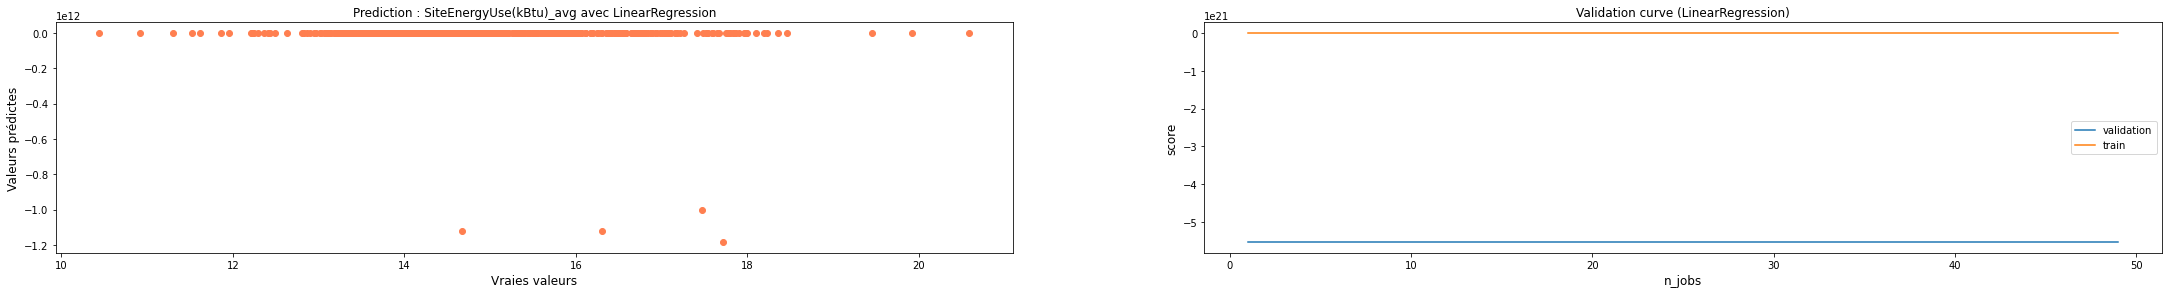

--------
Lasso
Score entrainement: -0.0009860999496147382
Cross: -0.0013825117928456532
MAE : 1.0785629289212049
MSE : 1.8824368817148918
RMSE : 1.3720192716266386


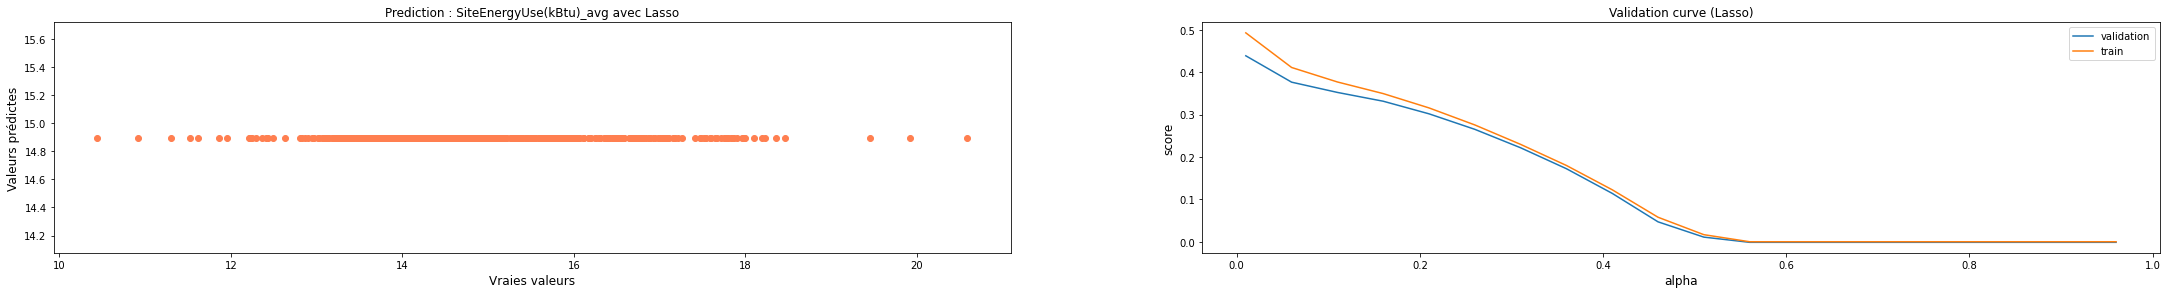

--------
Ridge
Score entrainement: -0.8875090659932525
Cross: 0.49601679092784084
MAE : 0.7814809762760885
MSE : 3.5496164038399476
RMSE : 1.8840425695402818


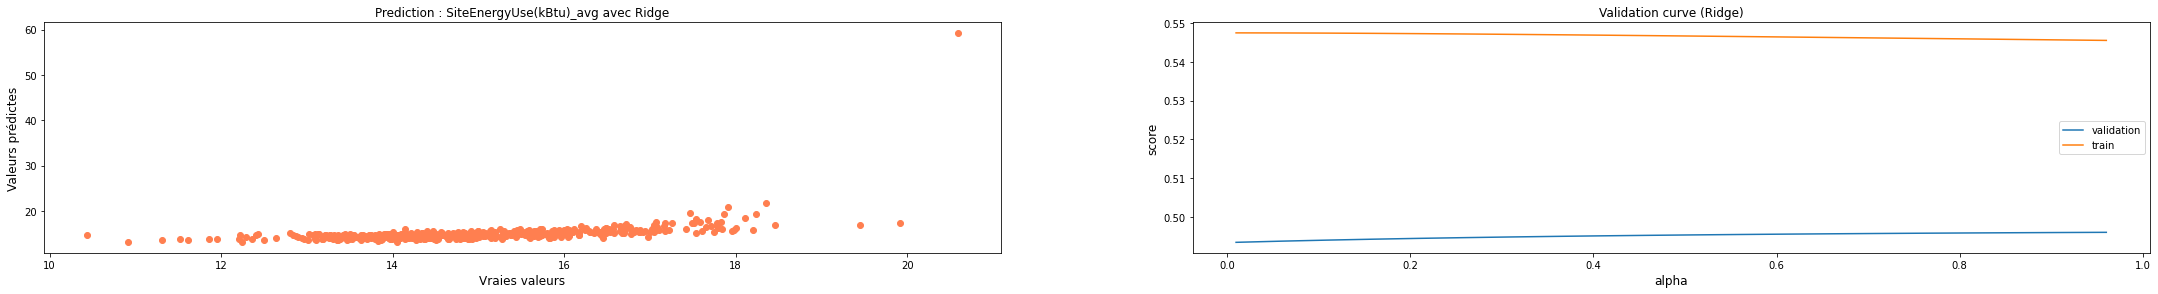

--------
ElasticNet
Score entrainement: 0.0030462815269785004
Cross: 0.007332930709173291
MAE : 1.077122181102178
MSE : 1.874853655920782
RMSE : 1.369252955417947


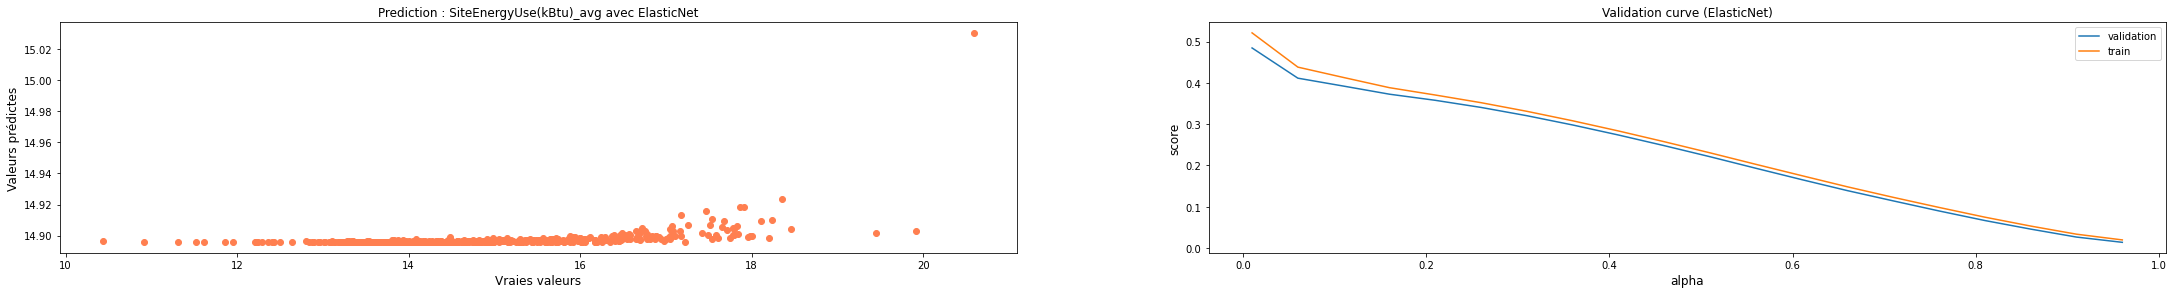

--------
RandomForestRegressor
Score entrainement: 0.6947197908703643
Cross: 0.6546594886411045
MAE : 0.5487434976788563
MSE : 0.5741046004057276
RMSE : 0.757696905368979


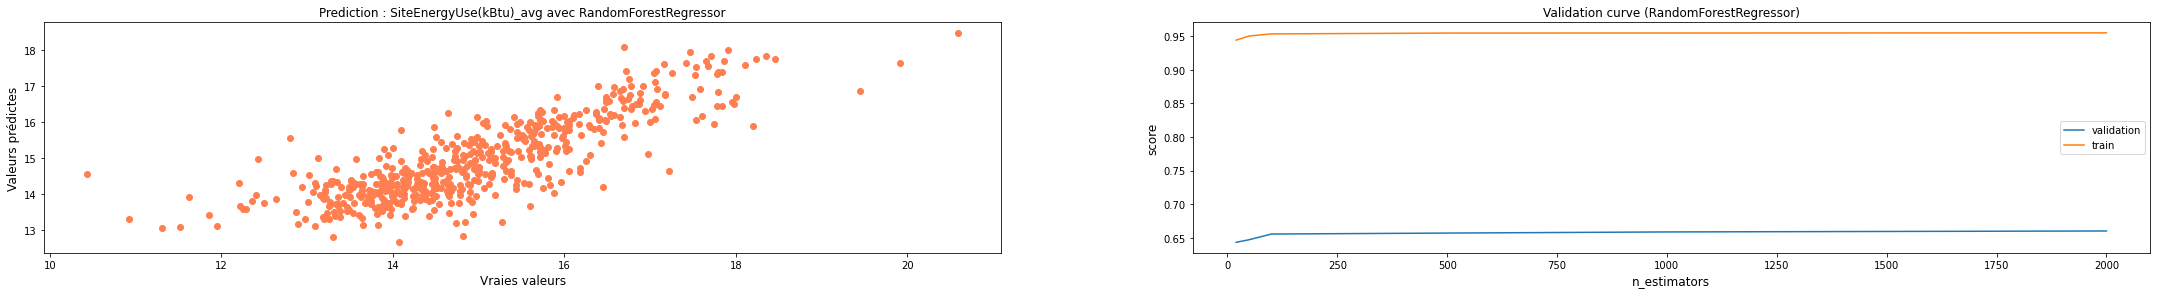

--------
XGBRegressor
Score entrainement: 0.7052837776110792
Cross: 0.680862695326796
MAE : 0.5433318175982714
MSE : 0.5542381524503868
RMSE : 0.7444717270994157


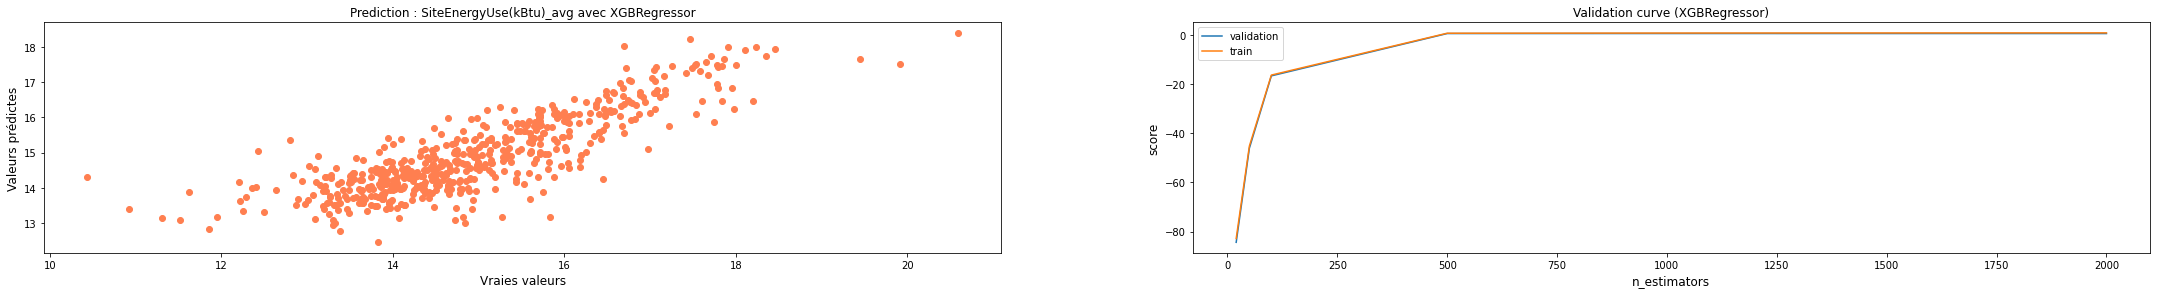

--------
SVR
Score entrainement: 0.6586902191256132
Cross: 0.6237457842179891
MAE : 0.5938298572293542
MSE : 0.6418611803303902
RMSE : 0.8011623932327266


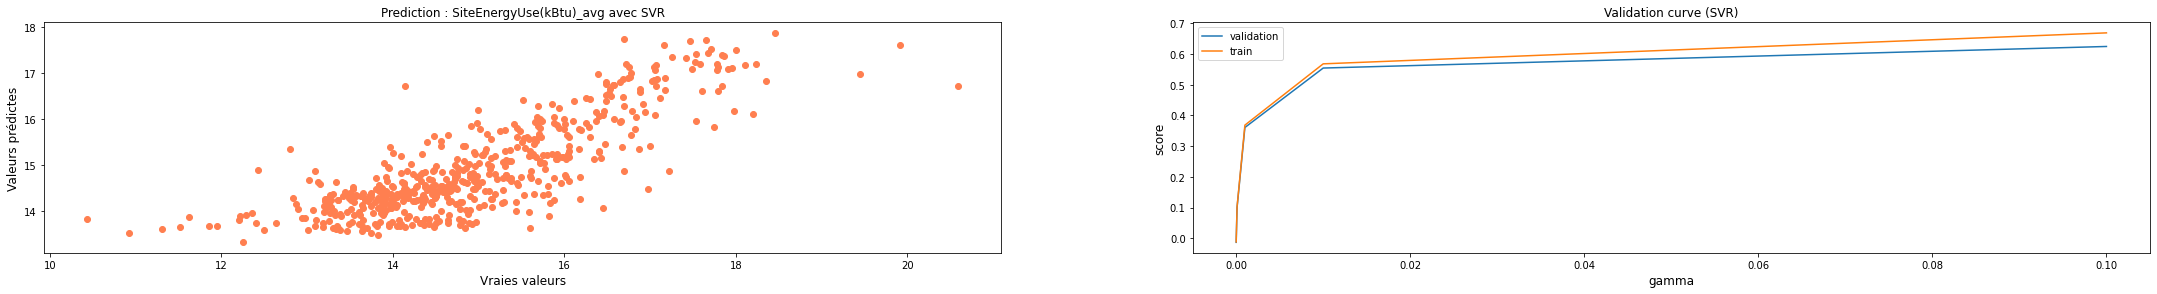

--------


In [19]:
df_energy = training_model(df[liste_train],Y['SiteEnergyUse(kBtu)_avg'], random_state=0)

#### Emissions
##### Scoring des différents modèles


LinearRegression
Score entrainement: -4.220373226575075e+21
Cross: -9.933369119509288e+21
MAE : 8018020645.294805
MSE : 8.968204414529113e+21
RMSE : 94700604087.45613


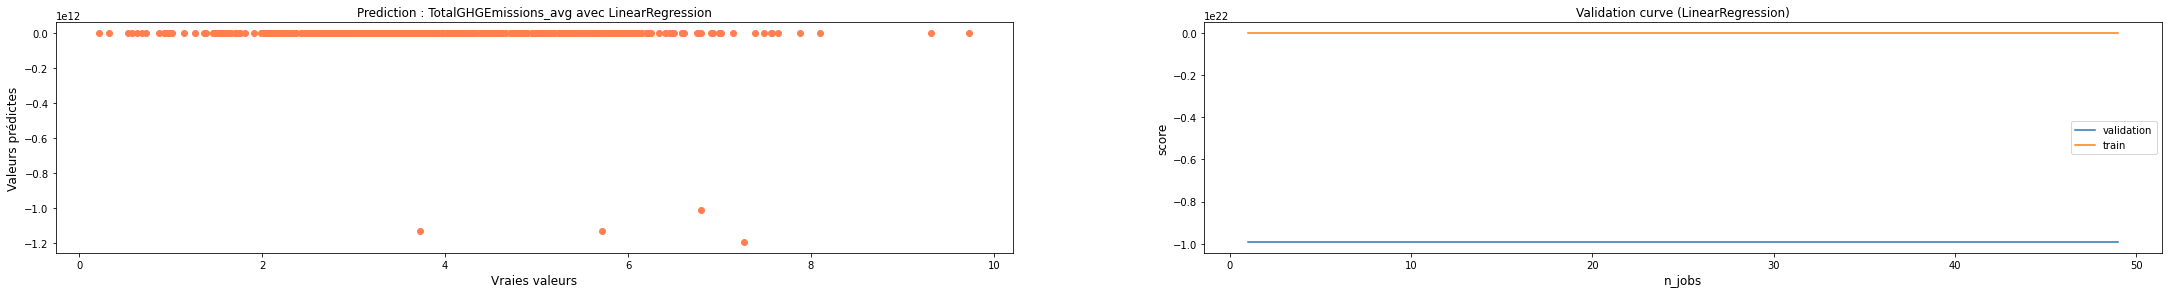

--------
Lasso
Score entrainement: -0.0002308643211774708
Cross: -0.004946718436804343
MAE : 1.1456394748457859
MSE : 2.1254695666413905
RMSE : 1.4578990248441044


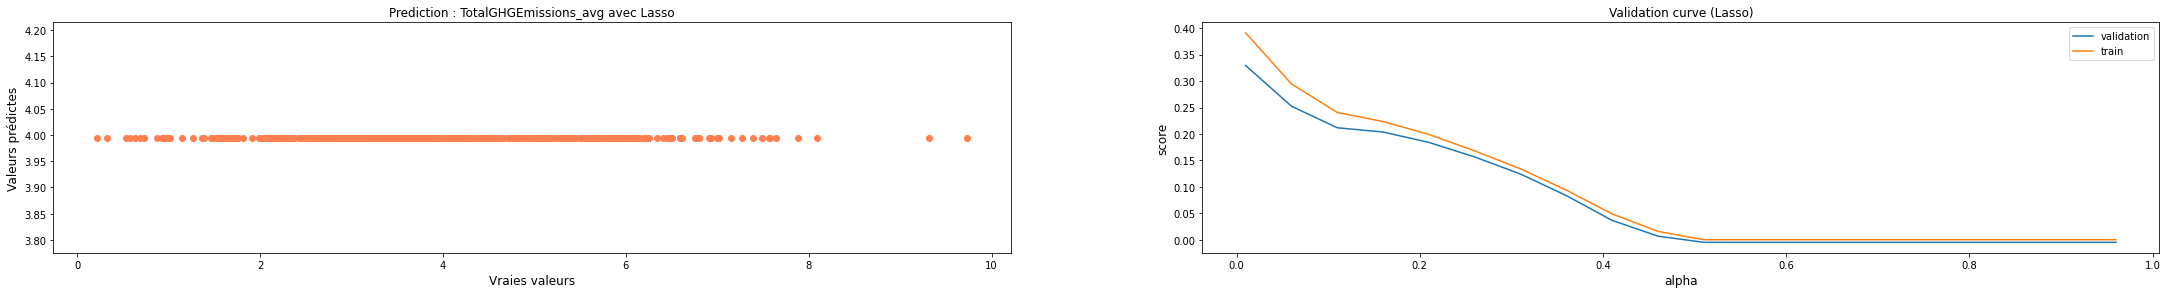

--------
Ridge
Score entrainement: -1.0323965756754134
Cross: 0.38126180805226106
MAE : 0.9494115726700423
MSE : 4.31880001211117
RMSE : 2.078172276812288


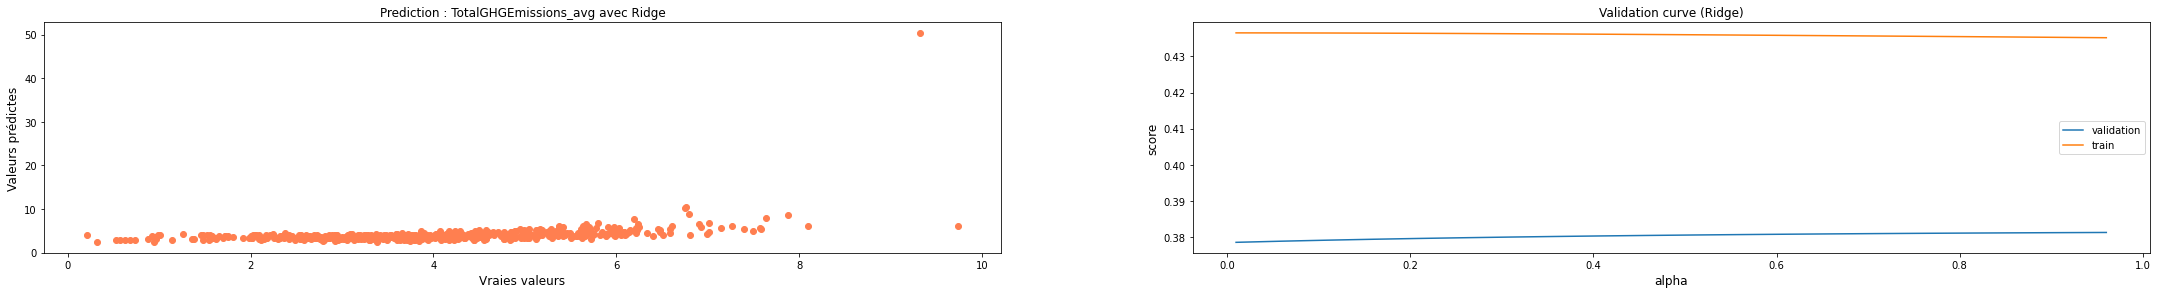

--------
ElasticNet
Score entrainement: -0.0002308643211774708
Cross: -0.004946718436804343
MAE : 1.1456394748457859
MSE : 2.1254695666413905
RMSE : 1.4578990248441044


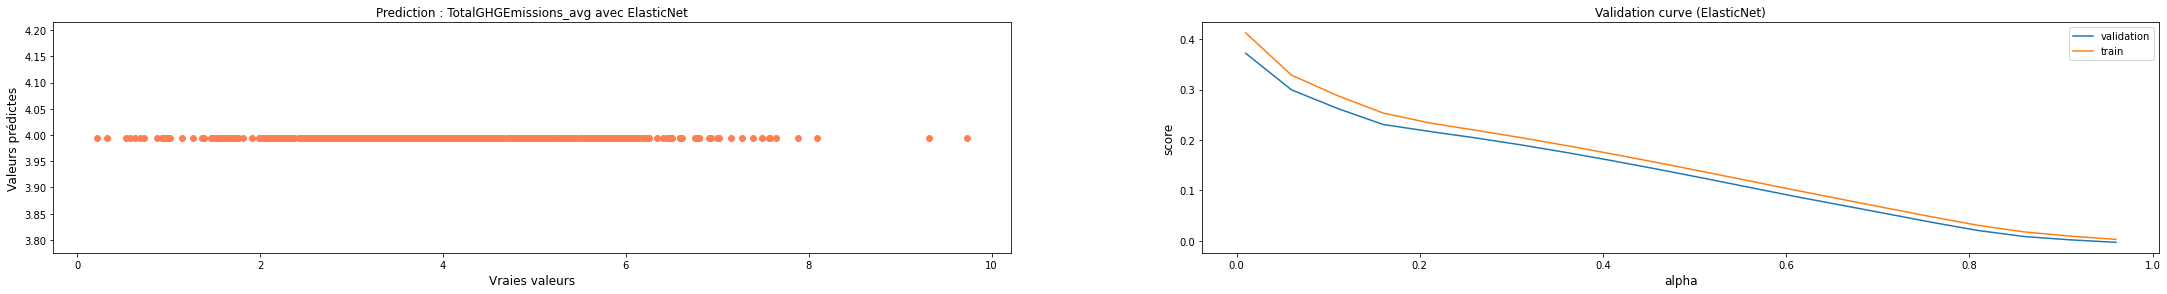

--------
RandomForestRegressor
Score entrainement: 0.5269047185709825
Cross: 0.49187321667306155
MAE : 0.7736618958886793
MSE : 1.0053175308496929
RMSE : 1.0026552402743891


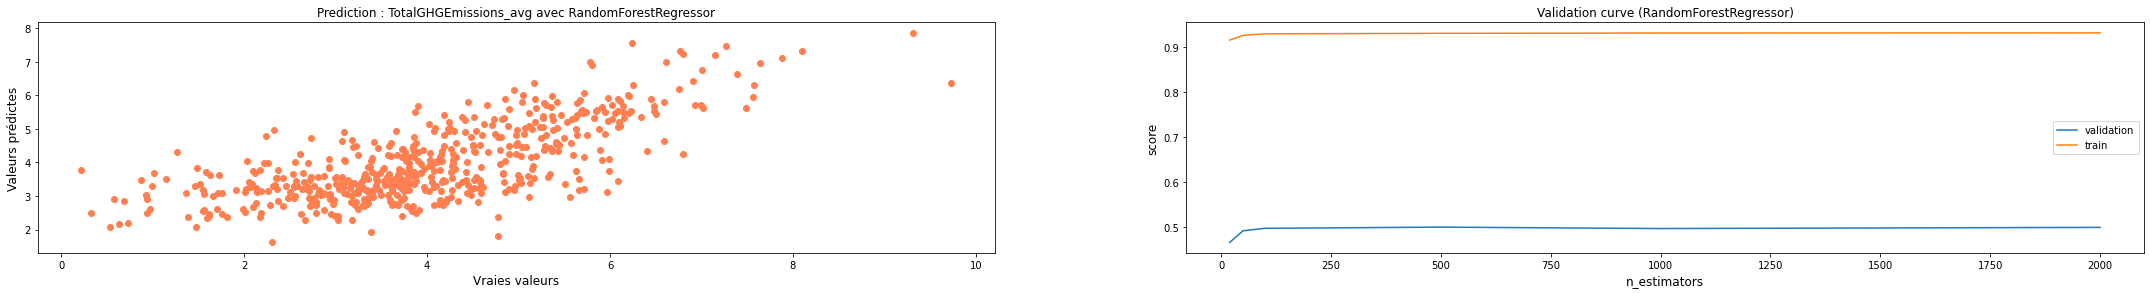

--------
XGBRegressor
Score entrainement: 0.5284011340293508
Cross: 0.49512603366223706
MAE : 0.7878155520639566
MSE : 1.0021376794481147
RMSE : 1.001068269124596


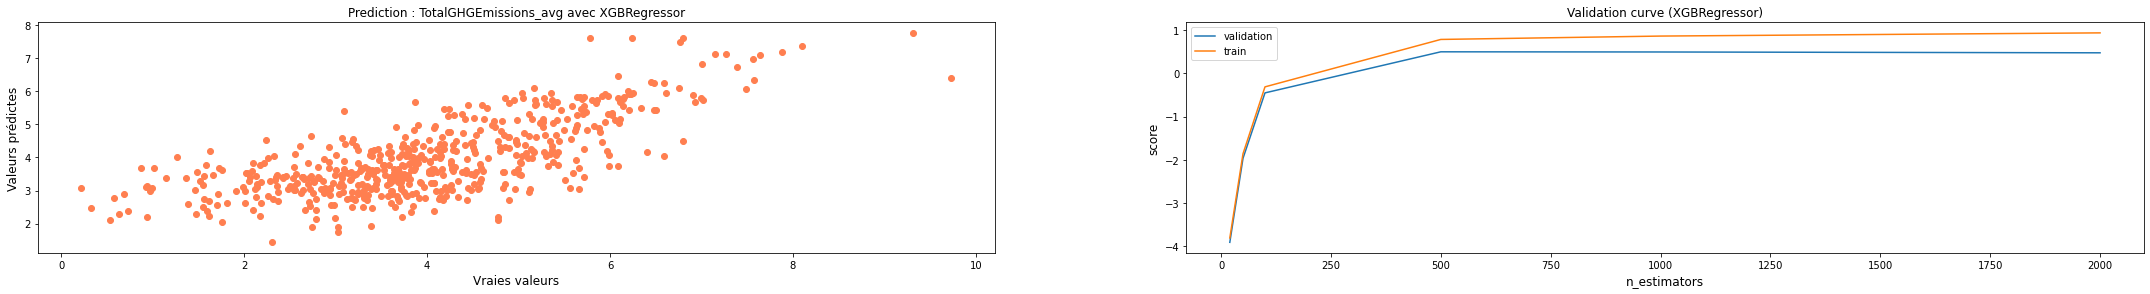

--------
SVR
Score entrainement: 0.4854816740482155
Cross: 0.46661952177648375
MAE : 0.8090524160336833
MSE : 1.0933406299474446
RMSE : 1.0456292985314846


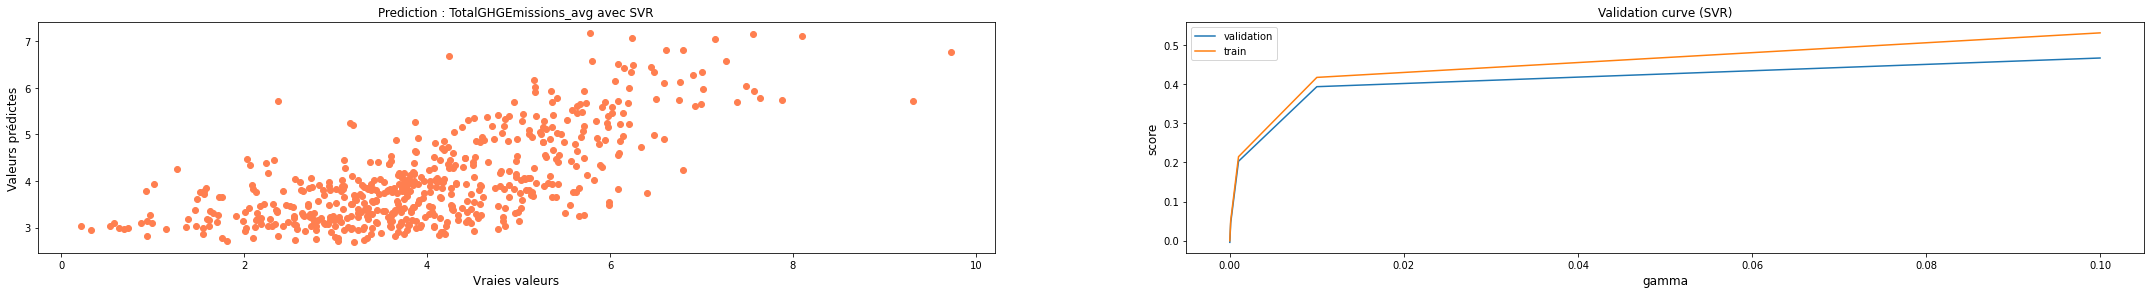

--------


In [20]:
df_ghg = training_model(df[liste_train], Y['TotalGHGEmissions_avg'], random_state=0)

## Modèle final

In [21]:
df_energy.set_index('Model')

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-4693778974802968576000.0,-5536524415656781676544.0,7954665586.506675,8827038314749600202752.0,93952319368.654221
Lasso,-0.000986,-0.001383,1.078563,1.882437,1.372019
Ridge,-0.887509,0.496017,0.781481,3.549616,1.884043
ElasticNet,0.003046,0.007333,1.077122,1.874854,1.369253
RandomForestRegressor,0.69472,0.654659,0.548743,0.574105,0.757697
XGBRegressor,0.705284,0.680863,0.543332,0.554238,0.744472
SVR,0.65869,0.623746,0.59383,0.641861,0.801162


In [22]:
df_ghg.set_index('Model')

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-4220373226575075213312.0,-9933369119509288321024.0,8018020645.294805,8968204414529112637440.0,94700604087.456131
Lasso,-0.000231,-0.004947,1.145639,2.12547,1.457899
Ridge,-1.032397,0.381262,0.949412,4.3188,2.078172
ElasticNet,-0.000231,-0.004947,1.145639,2.12547,1.457899
RandomForestRegressor,0.526905,0.491873,0.773662,1.005318,1.002655
XGBRegressor,0.528401,0.495126,0.787816,1.002138,1.001068
SVR,0.485482,0.46662,0.809052,1.093341,1.045629


<span style="color: #F00000"> Note : Augmenter le random_state augmente le score training, mais diminue la cross validation.</span>

### Choix de l'algorithme 
<span style="color: #26B260">On retient xgbscore qui affiche le meilleur score</span>

<span style="color: #FF7F00">Toutefois, nous allons optimiser les paramètres de RandomForestRegressor et SVR, qui affichait un score relativement proche. </span>

### Optimisation paramètres
#### Energy



In [23]:
# https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663 optimiser xgbregressor

# max_depth: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit.
# The value must be an integer greater than 0. Default is 6.

# learning_rate: The learning rate determines the step size at each iteration while your model optimizes toward its objective. 
# A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum.
# The value must be between 0 and 1. Default is 0.3.

# n_estimators: The number of trees in our ensemble. Equivalent to the number of boosting rounds.
# The value must be an integer greater than 0. Default is 100.
# NB: In the standard library, this is referred as num_boost_round.

Y_target = Y['SiteEnergyUse(kBtu)_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df[liste_train],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)

def objective_energy(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    # Au départ, il y avait une fonction par modèle, mais ce n'était pas vraiment pas opti...

    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])
    
                   
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation


study_energy= optuna.create_study(direction="maximize", study_name="optimisation_ML_energy", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_energy.optimize(objective_energy, n_trials=30, show_progress_bar=True, n_jobs=-1) # dû au n_jobs=-1, il en fait parfois un peu plus que 150

# pour ouvrir une study recente : loaded_study = optuna.load_study(study_name="my_study", storage="sqlite:///example.db")

[I 2022-05-17 15:46:52,561] Using an existing study with name 'optimisation_ML_energy' instead of creating a new one.
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-17 15:47:06,260] Trial 450 finished with value: 0.6358293154826022 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 834, 'learning_rate': 0.18000000000000002, 'max_depth': 7}. Best is trial 425 with value: 0.6843739291882716.
[I 2022-05-17 15:47:07,305] Trial 451 finished with value: 0.6407328648229986 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 841, 'learning_rate': 0.16, 'max_depth': 7}. Best is trial 425 with value: 0.6843739291882716.
[I 2022-05-17 15:47:08,156] Trial 445 finished with value: 0.6747048135785259 and parameters: {'classifier': 'XGBRegressor', 'n_estimators': 831, 'learning_rate': 0.02, 'max_depth': 7}. Best is trial 425 with value: 0.6

In [24]:
trial_energy = study_energy.best_trial
print(f'cross_validation : {trial_energy.value}')
print(f'Meilleurs hyperparamètres : {trial_energy.params}')

# cross_validation : 0.6848082622855352
# Meilleurs hyperparamètres : {'n_estimators': 247, 'learning_rate': 0.03, 'max_depth': 7}

# cross_validation : 0.6842875863460688
# Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 877}


cross_validation : 0.6843739291882716
Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 853}


In [25]:
optuna.visualization.plot_optimization_history(study_energy)

#### GHG


In [26]:
Y_target = Y['TotalGHGEmissions_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df[liste_train],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)

def objective_ghg(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])                    
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation

# La fonction prend du temps... on va donc stocker les résultats dans une db et la charger si besoin ! On passera évidemment le load_if_exists en False s'il y a des changements dans les étapes précédentes.
study_ghg = optuna.create_study(direction="maximize", study_name="optimisation_ML_ghg", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_ghg.optimize(objective_ghg, n_trials=30, n_jobs=-1)

[I 2022-05-17 15:48:02,131] Using an existing study with name 'optimisation_ML_ghg' instead of creating a new one.
[I 2022-05-17 15:48:23,515] Trial 420 finished with value: 0.5035404383757165 and parameters: {'classifier': 'RandomForest', 'n_estimators': 600, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-05-17 15:48:27,841] Trial 423 finished with value: 0.5012193285837668 and parameters: {'classifier': 'RandomForest', 'n_estimators': 749, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-05-17 15:48:27,864] Trial 425 finished with value: 0.5010229670362633 and parameters: {'classifier': 'RandomForest', 'n_estimators': 616, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-05-17 15:48:28,581] Trial 426 finished with value: 0.50034370013937 and parameters: {'classifier': 'RandomForest', 'n_estimators': 596, 'max_depth': 10}. Best is trial 237 with value: 0.504268011977552.
[I 2022-05-17 15:48:28,609] Trial 4

In [27]:
trial_ghg = study_ghg.best_trial
print(f'cross_validation : {trial_ghg.value}')
print(f'Meilleurs hyperparamètres : {trial_ghg.params}')

cross_validation : 0.504268011977552
Meilleurs hyperparamètres : {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 392}


## Resultat final

### Energy

In [28]:
classifier_energy, model_energy = predict_optuna(df[liste_train], Y['SiteEnergyUse(kBtu)_avg'], trial_energy)

df['Energy_predict_log'] = model_energy.predict(df[liste_train])
df['Energy_predict'] = np.exp(df['Energy_predict_log'])

0.7073056179344301
0.6843739291882716


### GHG

In [29]:
classifier_ghg, model_ghg = predict_optuna(df[liste_train], Y['TotalGHGEmissions_avg'], trial_ghg)

df['GHG_predict_log'] = model_ghg.predict(df[liste_train])
df['GHG_predict'] = np.exp(df['GHG_predict_log'])

0.5393840621915746
0.5026112576773215


## Features importance

In [30]:
liste_features = list(numerical_columns) + list(ohe.get_feature_names_out(categorical_columns))

### Energy

In [31]:
fig = feature_importance(model=model_energy, classifier=classifier_energy, index=liste_features)
fig.show()


### GHG

In [32]:
fig = feature_importance(model=model_ghg, classifier=classifier_ghg, index=liste_features)
fig.show()


## Comparaison résultat réel et prédictions

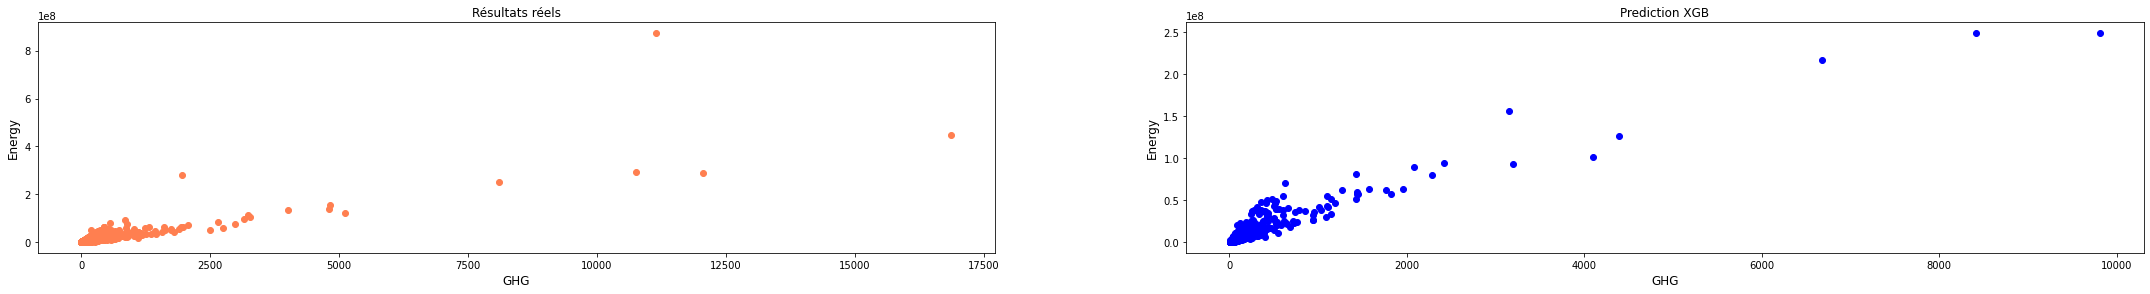

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
        
ax1.scatter(df['TotalGHGEmissions_avg'], df['SiteEnergyUse(kBtu)_avg'], c='coral')
ax1.set_title(f'Résultats réels')
ax1.set_xlabel("GHG", size = 12)
ax1.set_ylabel("Energy", size = 12)
        
ax2.scatter(df['GHG_predict'], df['Energy_predict'], c='b')
ax2.set_title(f'Prediction XGB')
ax2.set_xlabel("GHG", size = 12)
ax2.set_ylabel("Energy", size = 12)     

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

plt.show()

In [34]:
df[(df['TotalGHGEmissions_avg'] - df['GHG_predict'])> 2000]

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,25,26,27,28,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Energy_predict_log,Energy_predict,GHG_predict_log,GHG_predict
34,43,Campus,-0.068950,-0.170288,47.534930,-122.317880,Office,1.268990,0.0,494835.0,...,0.0,0.0,0.0,0.0,19.921163,9.733350,17.490227,39437464.0,6.273342,530.246659
166,276,NonResidential,2.679240,0.594419,47.603990,-122.323770,Hospital (General Medical & Surgical),3.509805,0.0,1158691.0,...,0.0,0.0,0.0,0.0,19.500626,9.283368,19.334780,249452656.0,9.037619,8413.719378
607,828,NonResidential,1.992192,1.512067,47.608951,-122.322402,Hospital (General Medical & Surgical),5.559647,0.0,1765970.0,...,0.0,0.0,0.0,0.0,19.482456,9.398149,19.334780,249452656.0,9.191505,9813.406081
1643,49967,Campus,37.718651,-0.629112,47.656440,-122.310410,Education,31.058446,0.0,9320156.0,...,0.0,0.0,0.0,0.0,20.588504,9.318348,18.310694,89584576.0,7.638048,2075.688001


In [35]:
df[(df['SiteEnergyUse(kBtu)_avg'] - df['Energy_predict'])> 5000000]
# essayer d'expliquer d'où viennent les écarts (les batiments ont-ils des points communs ?)
# suivent-ils une loi normale ? Un type de batiment en particulier ?

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,Latitude,Longitude,LargestPropertyUseType,PropertyGFATotal_avg,PropertyGFAParking_avg,PropertyGFABuilding(s)_avg,...,25,26,27,28,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Energy_predict_log,Energy_predict,GHG_predict_log,GHG_predict
2,3,NonResidential,-0.068950,5.641483,47.61393,-122.33810,Hotel/Senior Care/Housing,2.835926,98359.0,860691.0,...,0.0,0.0,0.0,0.0,18.104034,7.637900,17.821991,5.495312e+07,7.006015,1103.249565
3,5,NonResidential,-0.068950,0.900301,47.61412,-122.33664,Hotel/Senior Care/Housing,-0.194319,0.0,61320.0,...,0.0,0.0,0.0,0.0,16.678394,7.013362,15.633067,6.156796e+06,6.002155,404.299107
5,9,Nonresidential COS,-0.068950,-0.323229,47.61623,-122.33657,Police Station,-0.072911,37198.0,60090.0,...,0.0,0.0,0.0,0.0,16.306176,5.714442,15.194798,3.972068e+06,4.216834,67.818418
9,15,NonResidential,-0.068950,1.053243,47.60695,-122.33414,Hotel/Senior Care/Housing,0.115692,19279.0,133884.0,...,0.0,0.0,0.0,0.0,16.547814,6.451962,16.114418,9.963291e+06,5.825714,338.902882
16,23,NonResidential,-0.068950,3.653245,47.60681,-122.33078,Hotel/Senior Care/Housing,1.003835,85000.0,331281.0,...,0.0,0.0,0.0,0.0,17.324475,6.658017,17.046980,2.531683e+07,6.572727,715.317805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,49865,NonResidential,-0.068950,0.288536,47.66246,-122.29898,Lifestyle Center,0.643174,119626.0,189807.0,...,0.0,0.0,0.0,0.0,17.066510,6.690675,16.828161,2.034125e+07,6.289922,539.111293
1634,49918,Nonresidential COS,-0.068950,-0.476171,47.52472,-122.27074,Loisirs,-0.229004,0.0,51044.5,...,0.0,0.0,0.0,0.0,16.387375,6.223508,15.234053,4.131093e+06,5.071401,159.397519
1638,49940,NonResidential,-0.068950,0.594419,47.60986,-122.32774,Hospital (General Medical & Surgical),0.862690,0.0,374466.0,...,0.0,0.0,0.0,0.0,18.613769,8.539436,18.438919,1.018406e+08,8.317240,4093.847176
1643,49967,Campus,37.718651,-0.629112,47.65644,-122.31041,Education,31.058446,0.0,9320156.0,...,0.0,0.0,0.0,0.0,20.588504,9.318348,18.310694,8.958458e+07,7.638048,2075.688001


# Prediction avec Energystar
Maintenant que nous avons fini avec notre data, nous allons refaire les mêmes étapes avec le energystar.
## Séparation des types de variable

In [36]:
# Séparation des types de variables...

categorical_columns_star = df_filtre_categorical(df_energystar)
numerical_columns_star = df_filtre_numerical(df_energystar)

## Variables object

In [37]:
# on encode les variables catégoriques...

ohe_star, df_ohe_star = df_encodage_categorie(df_energystar, categorical_columns_star)

# # On réinitialise l'index pour que ça colle avec le df_ohe
df_energystar.reset_index(drop=True, inplace=True)

df_energystar[df_ohe_star.columns.values] = df_ohe_star

## Variables numériques

In [38]:
# on s'occupe des variables numériques avec le standardscaler

df_energystar[numerical_columns_star] = df_scaling_numeric(df_energystar, numerical_columns_star)

## Variables Y

In [39]:
# on sépare les variables Y
Y_star = ['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']
Y_star = df_energystar[Y_star]
Y_star

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,7.103895e+06,249.705
1,8.371084e+06,279.685
2,7.285884e+07,2075.380
3,1.751195e+07,1111.385
4,1.450085e+07,506.355
...,...,...
1102,4.420650e+06,134.800
1103,1.325973e+06,9.240
1104,5.026677e+05,3.500
1105,3.878100e+05,7.790


In [40]:
# On sait via df que la distribution n'est pas normale, donc on applique un log

Y_star = np.log(1+Y_star)
df_energystar[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']] = np.log(df_energystar[['SiteEnergyUse(kBtu)_avg', 'TotalGHGEmissions_avg']]) 
Y_star

,SiteEnergyUse(kBtu)_avg,TotalGHGEmissions_avg
0,15.776154,5.524277
1,15.940294,5.637233
2,18.104034,7.638381
3,16.678394,7.014262
4,16.489718,6.229211
...,...,...
1102,15.301798,4.911183
1103,14.097658,2.326302
1104,13.127687,1.504077
1105,12.868273,2.173615


In [41]:
liste_train_star = numerical_columns_star.tolist() + df_ohe_star.columns.values.tolist()

## Modèle final

### Energy

LinearRegression
Score entrainement: 0.6958367988915846
Cross: 0.6105911635382297
MAE : 0.5462492952352136
MSE : 0.4713674315796082
RMSE : 0.6865620376773014


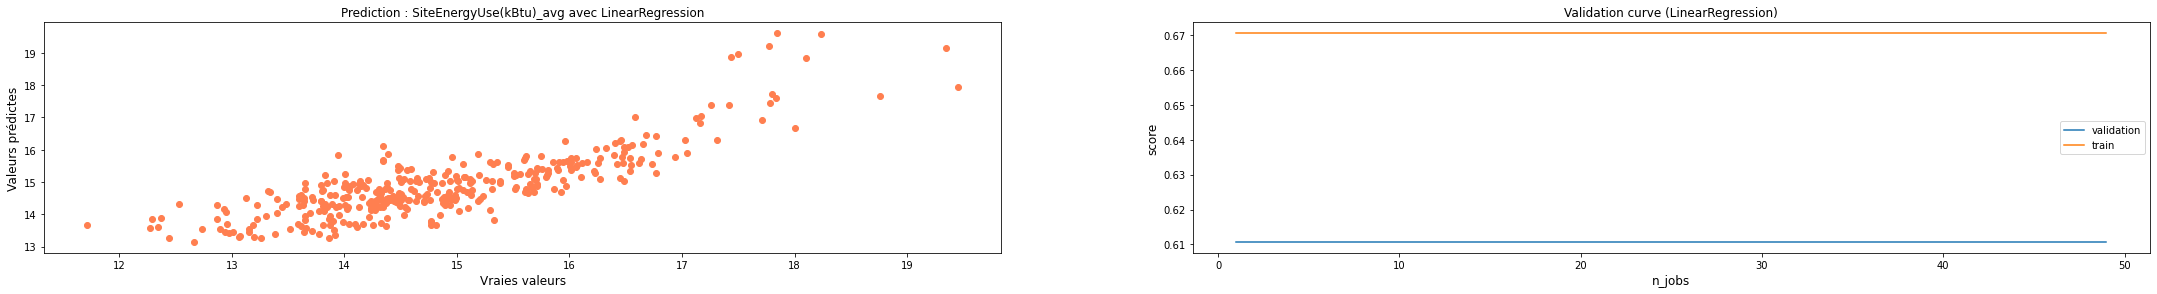

--------
Lasso
Score entrainement: -0.012122898144603544
Cross: -0.030673337729696337
MAE : 1.0038187321560592
MSE : 1.568505885007703
RMSE : 1.2524000499072583


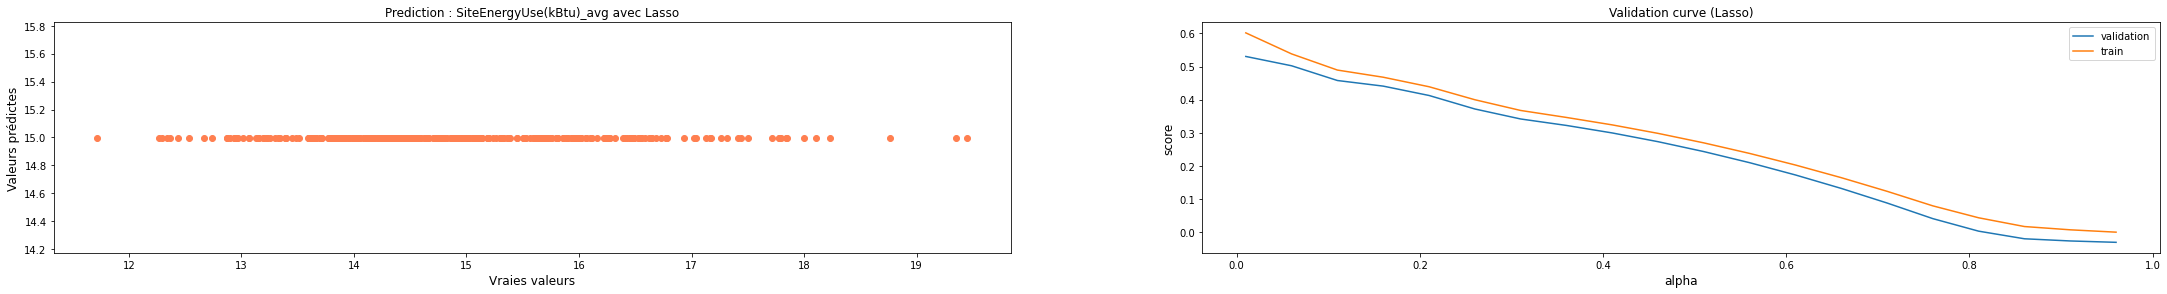

--------
Ridge
Score entrainement: 0.6905756080749403
Cross: 0.6109668101446782
MAE : 0.5482057793791604
MSE : 0.4795207979081267
RMSE : 0.6924744023486549


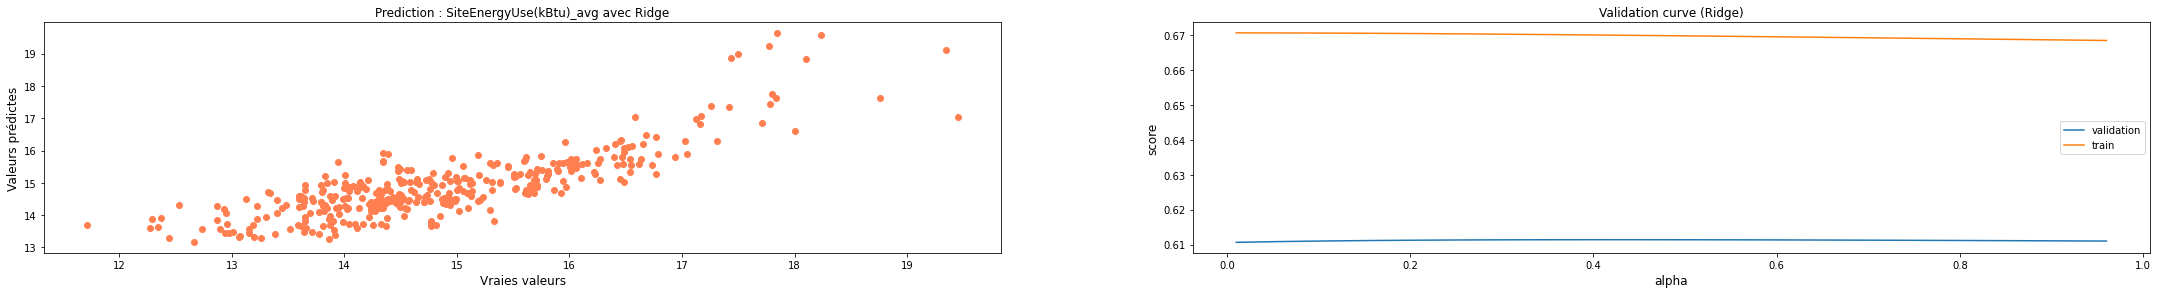

--------
ElasticNet
Score entrainement: 0.2355960598548167
Cross: 0.2010929102243276
MAE : 0.8840938132929488
MSE : 1.1846111582286294
RMSE : 1.0883984372593656


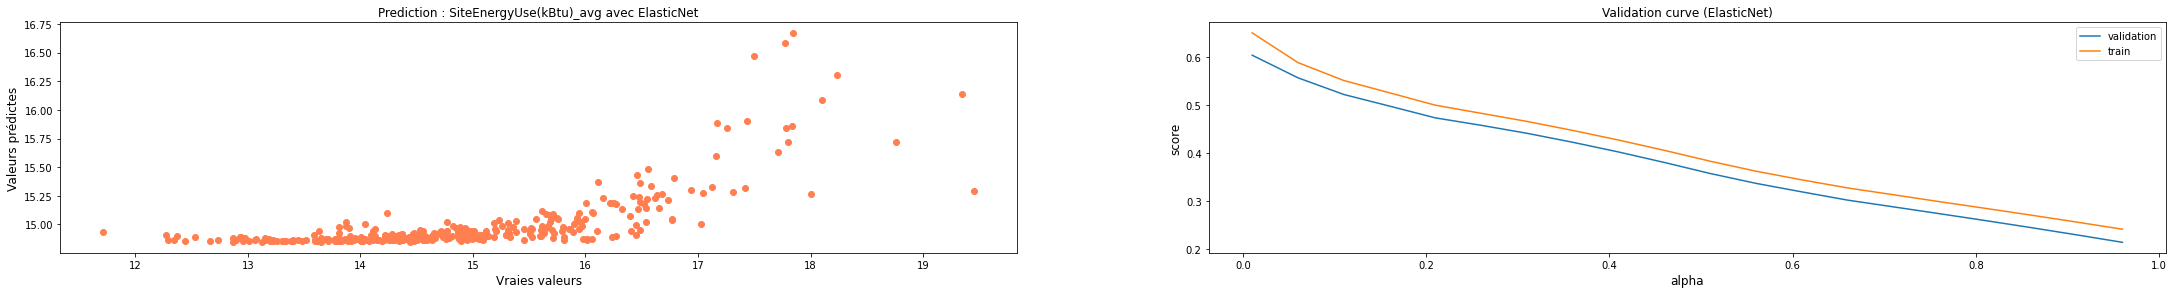

--------
RandomForestRegressor
Score entrainement: 0.8332598247352406
Cross: 0.8120175833010563
MAE : 0.3485971254287546
MSE : 0.2584003846266358
RMSE : 0.5083309794087272


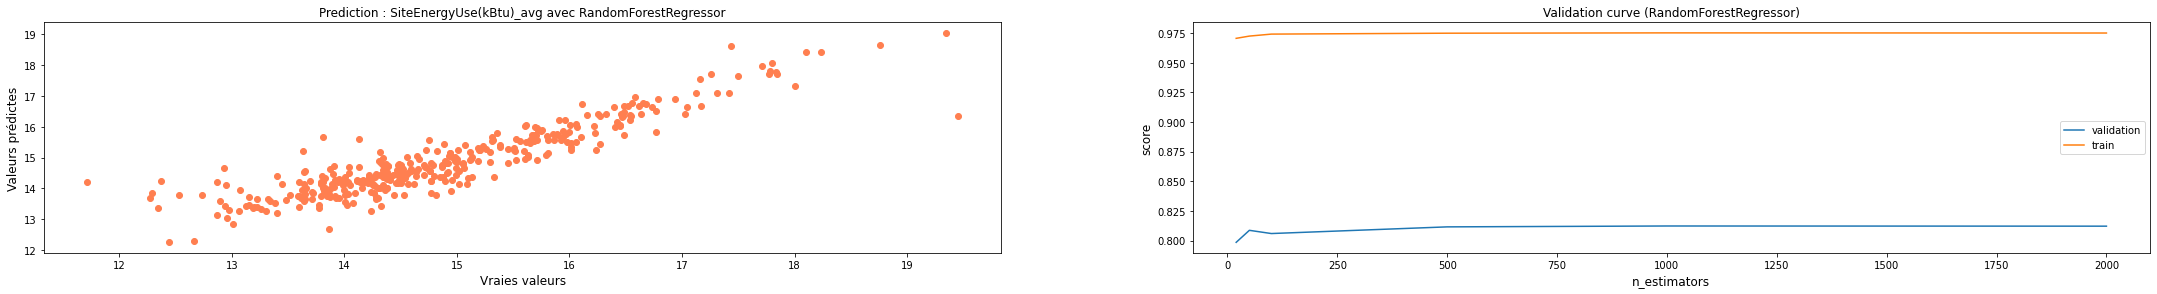

--------
XGBRegressor
Score entrainement: 0.8538920545861354
Cross: 0.8444470379495093
MAE : 0.33524870896368947
MSE : 0.22642623010322296
RMSE : 0.4758426526733632


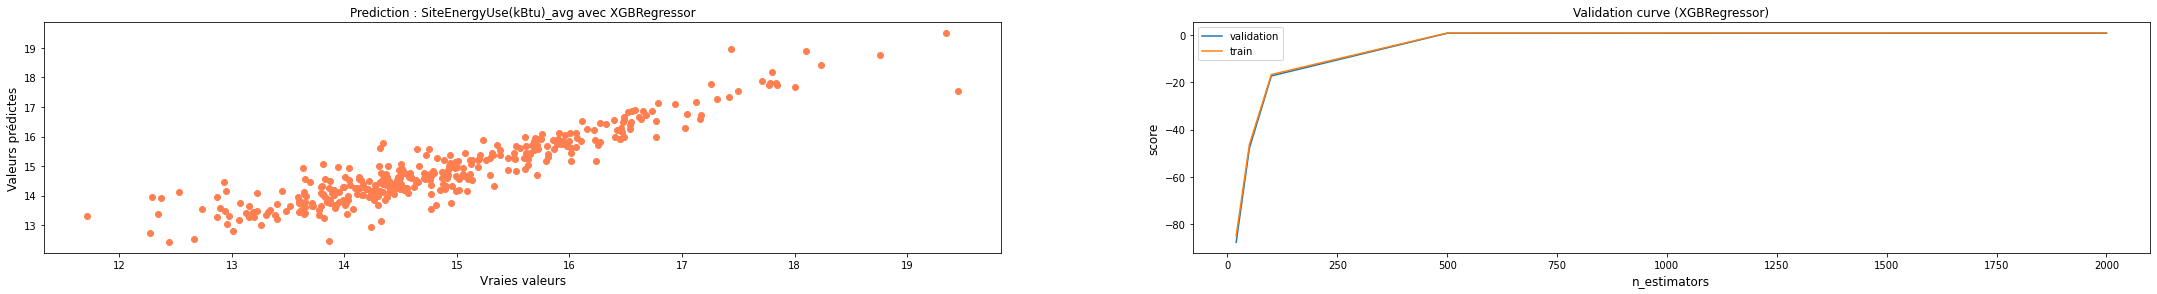

--------
SVR
Score entrainement: 0.7896557621777684
Cross: 0.750229330301977
MAE : 0.4010178513580849
MSE : 0.3259744202077058
RMSE : 0.570941695979288


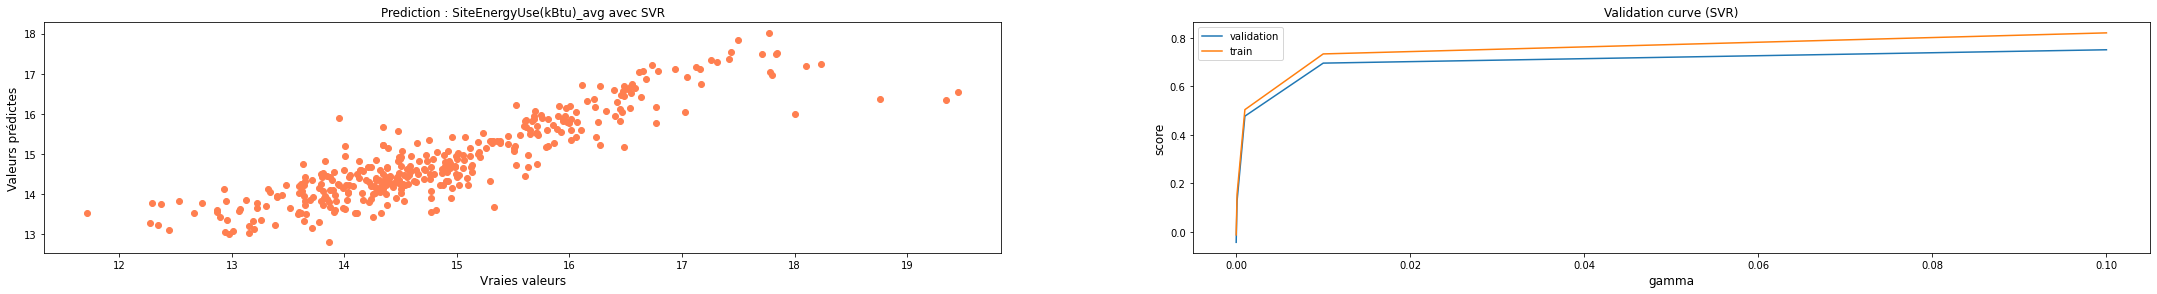

--------


In [42]:
df_energy_star = training_model(df_energystar[liste_train_star], Y_star['SiteEnergyUse(kBtu)_avg'], random_state=0)

### GHG

LinearRegression
Score entrainement: 0.5285616730361395
Cross: 0.4177045751746493
MAE : 0.771889880930354
MSE : 0.926478095733731
RMSE : 0.9625373217354904


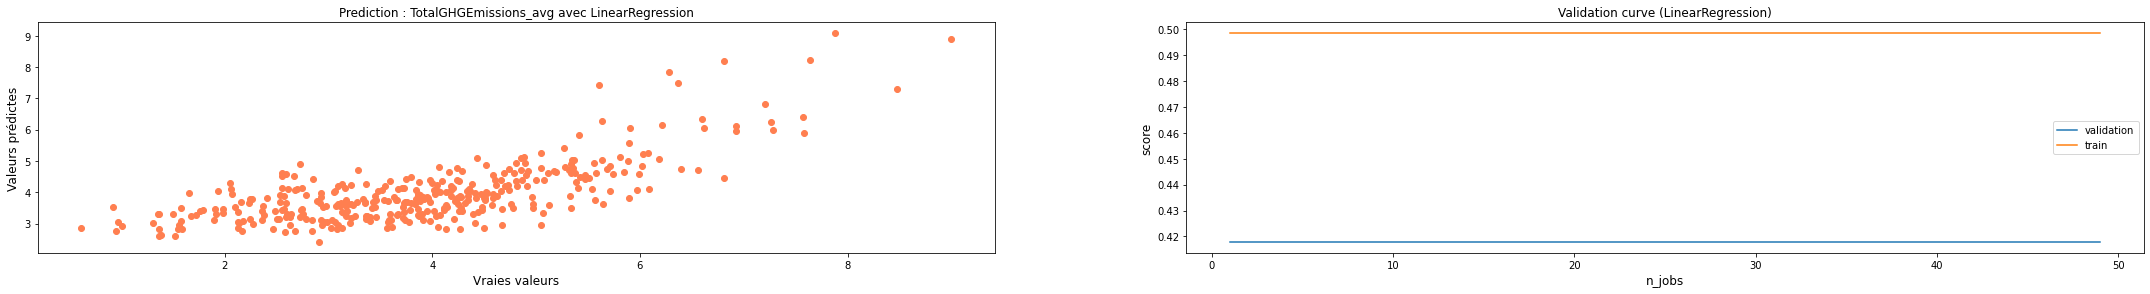

--------
Lasso
Score entrainement: -0.008681940811679167
Cross: -0.030533313850710543
MAE : 1.1072711218679587
MSE : 1.98227778751609
RMSE : 1.4079338718548147


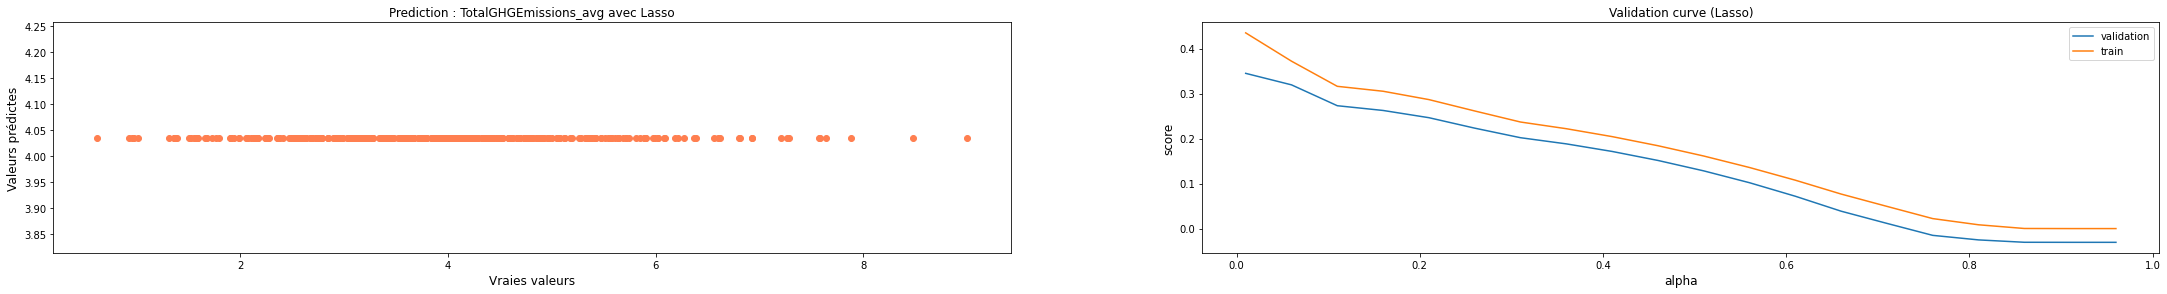

--------
Ridge
Score entrainement: 0.5246271973823373
Cross: 0.4213364583618858
MAE : 0.7745497489726694
MSE : 0.934210189844367
RMSE : 0.9665454928995153


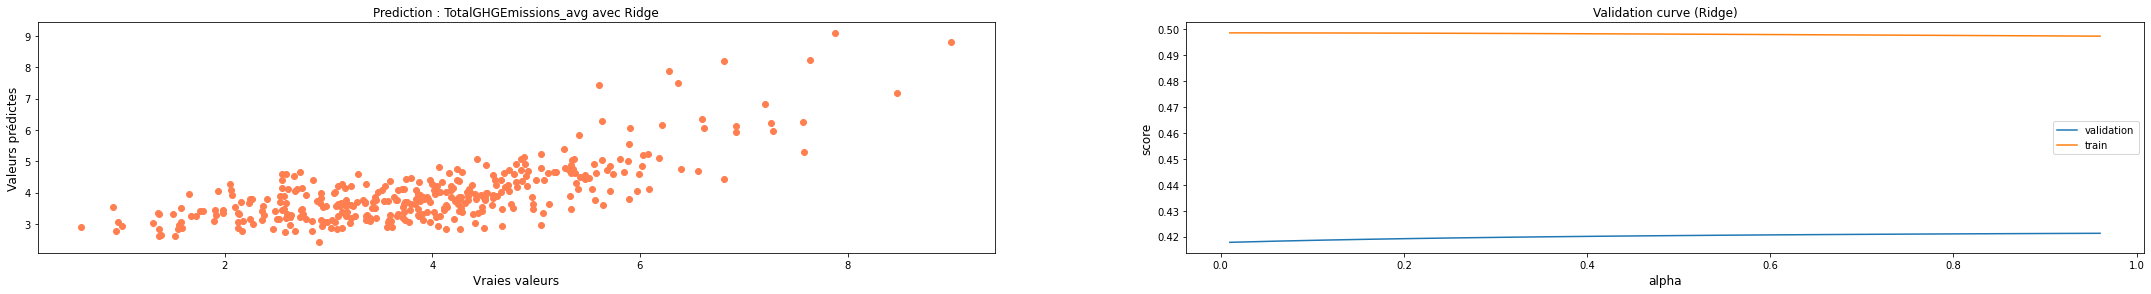

--------
ElasticNet
Score entrainement: 0.13120621674799215
Cross: 0.0994473014155215
MAE : 1.0333301055848376
MSE : 1.7073673561426994
RMSE : 1.3066626787900155


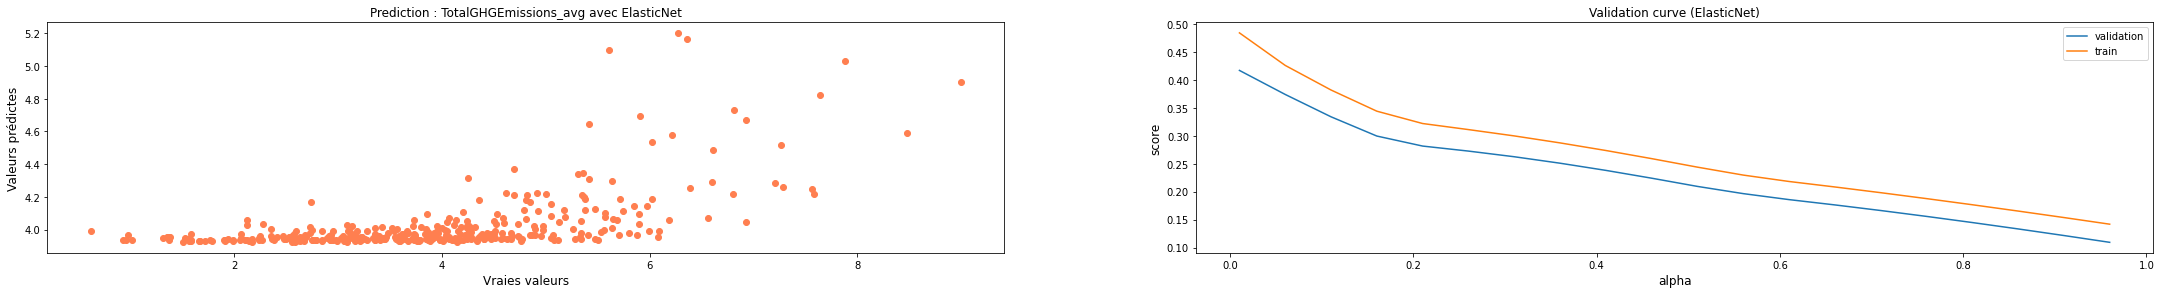

--------
RandomForestRegressor
Score entrainement: 0.6389399628998131
Cross: 0.5987083354040588
MAE : 0.6635953270762375
MSE : 0.7095609255455689
RMSE : 0.8423543942697568


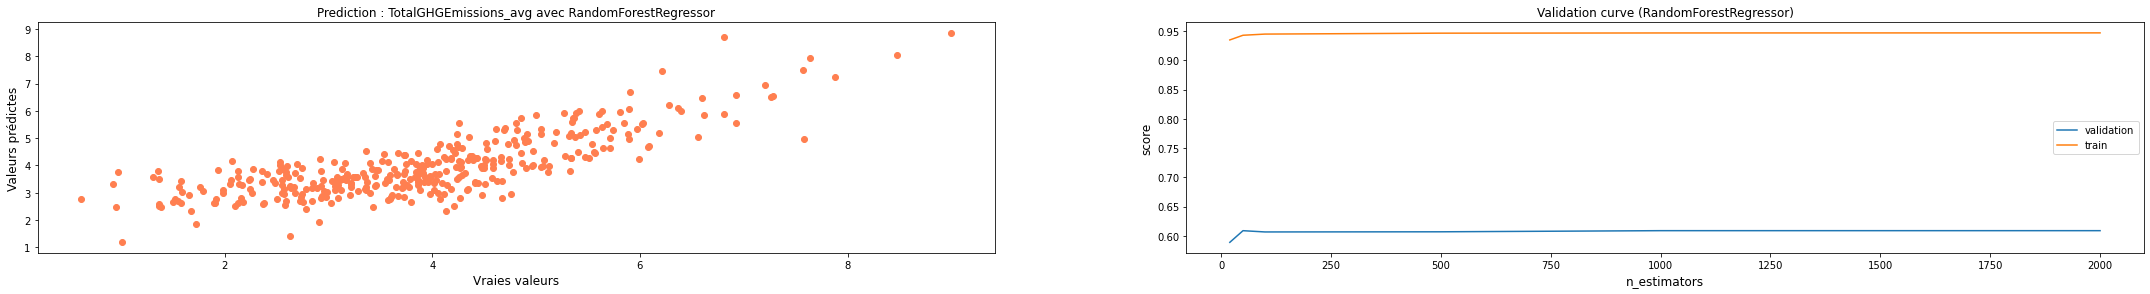

--------
XGBRegressor
Score entrainement: 0.6321044175310451
Cross: 0.5950270688662034
MAE : 0.6714480696650312
MSE : 0.7229942479853101
RMSE : 0.8502906844046394


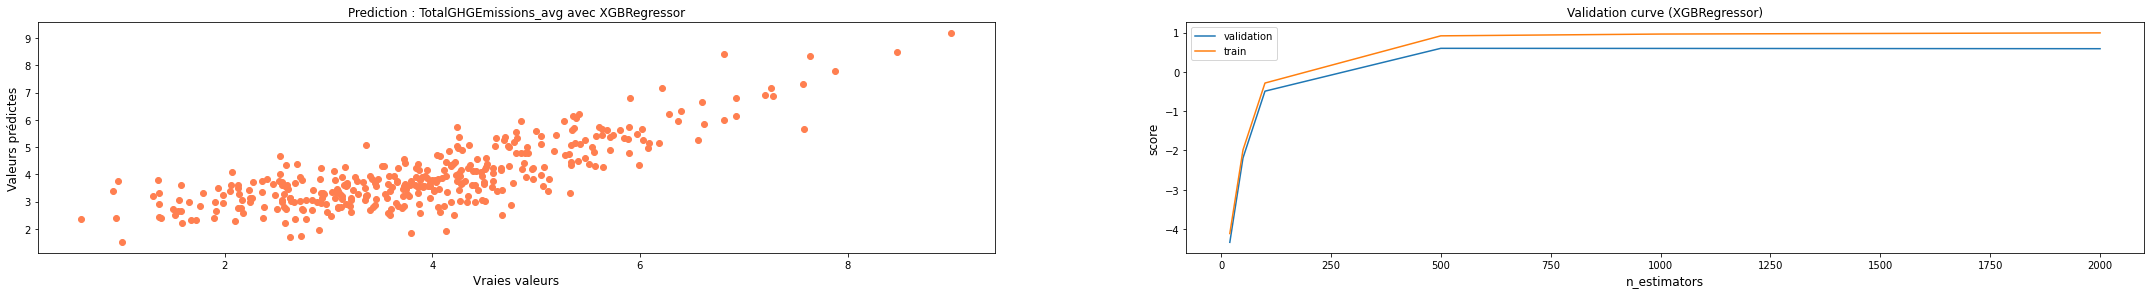

--------
SVR
Score entrainement: 0.5657709661280459
Cross: 0.5242648697593641
MAE : 0.7067684470998491
MSE : 0.8533538013442543
RMSE : 0.9237715092728582


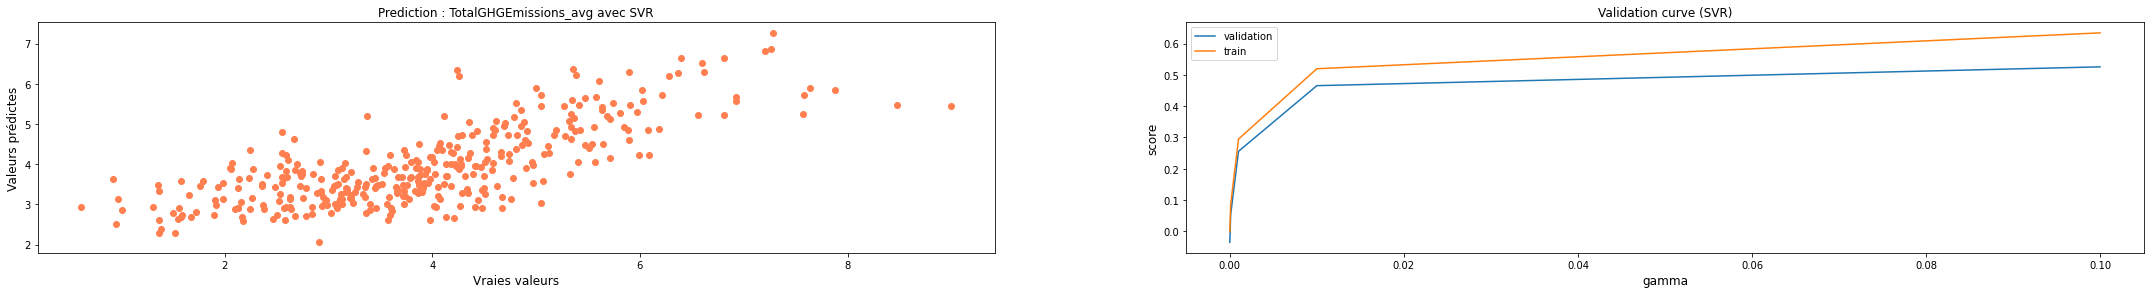

--------


In [43]:
df_ghg_star = training_model(df_energystar[liste_train_star], Y_star['TotalGHGEmissions_avg'], random_state=0)

## Optimisation paramètres
Même étape...
### Energy


In [44]:
Y_target = Y_star['SiteEnergyUse(kBtu)_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df_energystar[liste_train_star],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)

def objective_energy_star(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    # Au départ, il y avait une fonction par modèle, mais ce n'était pas vraiment pas opti...

    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])
    
                   
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation


study_energy_star= optuna.create_study(direction="maximize", study_name="optimisation_ML_energy_star", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_energy_star.optimize(objective_energy_star, n_trials=30, n_jobs=-1) # dû au n_jobs=-1, il en fait parfois un peu plus que 150

[I 2022-05-17 15:50:51,645] Using an existing study with name 'optimisation_ML_energy_star' instead of creating a new one.
[I 2022-05-17 15:50:52,570] Trial 185 finished with value: 0.7303010295166309 and parameters: {'classifier': 'SVR', 'gamma': 'scale', 'C': 0.6314518129038574, 'epsilon': 0.35644608662809996, 'kernel': 'rbf', 'max_iter': 300}. Best is trial 109 with value: 0.8481692973001952.
[I 2022-05-17 15:50:52,577] Trial 180 finished with value: 0.7297929875005129 and parameters: {'classifier': 'SVR', 'gamma': 'scale', 'C': 0.6268851488537073, 'epsilon': 0.39471844360282116, 'kernel': 'rbf', 'max_iter': 300}. Best is trial 109 with value: 0.8481692973001952.
[I 2022-05-17 15:50:52,585] Trial 181 finished with value: 0.7298135296689512 and parameters: {'classifier': 'SVR', 'gamma': 'scale', 'C': 0.6274506386211602, 'epsilon': 0.39421470951075716, 'kernel': 'rbf', 'max_iter': 300}. Best is trial 109 with value: 0.8481692973001952.
[I 2022-05-17 15:50:52,586] Trial 182 finished wi

In [45]:
trial_energy_star = study_energy_star.best_trial
print(f'cross_validation : {trial_energy_star.value}')
print(f'Meilleurs hyperparamètres : {trial_energy_star.params}')

cross_validation : 0.8481692973001952
Meilleurs hyperparamètres : {'classifier': 'XGBRegressor', 'learning_rate': 0.060000000000000005, 'max_depth': 5, 'n_estimators': 325}


### GHG

In [46]:
Y_target = Y_star['TotalGHGEmissions_avg']
        
X_train, X_test, y_train, y_test = train_test_split(df_energystar[liste_train_star],
                                                        Y_target,
                                                        test_size=0.33,
                                                        random_state=0)

def objective_ghg_star(trial):
    # Src : https://optuna.readthedocs.io/en/stable/
    
    regressor_name = trial.suggest_categorical('classifier', ['SVR','RandomForest', 'XGBRegressor'])                    
    
    if regressor_name == "XGBRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.3, step=0.01)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1)
    
    elif regressor_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 100,2000)
        max_depth= trial.suggest_int('max_depth',5,10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,n_jobs=-1)
        
    elif regressor_name == "SVR":
        gamma=trial.suggest_categorical('gamma',['auto','scale'])
        C = trial.suggest_float('C', 0.1, 1)
        epsilon = trial.suggest_float('epsilon', 0.01, 1)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
        
        model = svm.SVR(gamma=gamma, C=C, epsilon=epsilon, kernel=kernel, cache_size=7000, max_iter=max_iter)
                                

    model.fit(X_train, y_train)
    cross_validation = cross_val_score(model, X_train, y_train, cv=5).mean()
    return cross_validation

# La fonction prend du temps... on va donc stocker les résultats dans une db et la charger si besoin ! On passera évidemment le load_if_exists en False s'il y a des changements dans les étapes précédentes.
study_ghg_star = optuna.create_study(direction="maximize", study_name="optimisation_ML_ghg_star", storage='sqlite:///./bdd_optimisation_modele/optimisation.db', load_if_exists=True)
study_ghg_star.optimize(objective_ghg_star, n_trials=30, n_jobs=-1)

[I 2022-05-17 15:51:06,036] Using an existing study with name 'optimisation_ML_ghg_star' instead of creating a new one.
[I 2022-05-17 15:51:52,532] Trial 180 finished with value: 0.607665479568212 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1602, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-05-17 15:52:02,987] Trial 185 finished with value: 0.6079805743284709 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1830, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-05-17 15:52:04,435] Trial 186 finished with value: 0.6070936598779022 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1832, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-05-17 15:52:05,597] Trial 182 finished with value: 0.6052187073079935 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1612, 'max_depth': 10}. Best is trial 175 with value: 0.6093464443535271.
[I 2022-05-17 15:52:0

In [47]:
trial_ghg_star = study_ghg_star.best_trial
print(f'cross_validation : {trial_ghg.value}')
print(f'Meilleurs hyperparamètres : {trial_ghg.params}')

cross_validation : 0.504268011977552
Meilleurs hyperparamètres : {'max_depth': 10, 'n_estimators': 392}


### Resultat final

In [48]:
classifier_energy, model_energy = predict_optuna(df_energystar[liste_train_star], Y_star['SiteEnergyUse(kBtu)_avg'], trial_energy_star)

df_energystar['Energy_predict_log'] = model_energy.predict(df_energystar[liste_train_star])
df_energystar['Energy_predict'] = np.exp(df['Energy_predict_log'])

0.8561303867191383
0.8481692973001952


In [49]:
classifier_ghg, model_ghg = predict_optuna(df_energystar[liste_train_star], Y_star['TotalGHGEmissions_avg'], trial_ghg_star)

df_energystar['GHG_predict_log'] = model_ghg.predict(df_energystar[liste_train_star])
df_energystar['GHG_predict'] = np.exp(df_energystar['GHG_predict_log'])

0.6413739589495497
0.6064723727377559


In [50]:
liste_features_star = list(numerical_columns_star) + list(ohe_star.get_feature_names_out(categorical_columns_star))

In [51]:
fig = feature_importance(model=model_energy, classifier=classifier_energy, index=liste_features_star)
fig.show()

In [52]:
fig = feature_importance(model=model_ghg, classifier=classifier_ghg, index=liste_features_star)
fig.show()

# Comparaisons avec/sans EnergyStarScore
Impact sans optimisation des paramètres (l'opti a les mêmes scores) :

## Energy

In [53]:
df_energy_star.set_index('Model', inplace=True)
df_energy_star

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,0.695837,0.610591,0.546249,0.471367,0.686562
Lasso,-0.012123,-0.030673,1.003819,1.568506,1.2524
Ridge,0.690576,0.610967,0.548206,0.479521,0.692474
ElasticNet,0.235596,0.201093,0.884094,1.184611,1.088398
RandomForestRegressor,0.83326,0.812018,0.348597,0.2584,0.508331
XGBRegressor,0.853892,0.844447,0.335249,0.226426,0.475843
SVR,0.789656,0.750229,0.401018,0.325974,0.570942


In [54]:
df_energy.set_index('Model', inplace=True)
df_energy

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-4693778974802968576000.0,-5536524415656781676544.0,7954665586.506675,8827038314749600202752.0,93952319368.654221
Lasso,-0.000986,-0.001383,1.078563,1.882437,1.372019
Ridge,-0.887509,0.496017,0.781481,3.549616,1.884043
ElasticNet,0.003046,0.007333,1.077122,1.874854,1.369253
RandomForestRegressor,0.69472,0.654659,0.548743,0.574105,0.757697
XGBRegressor,0.705284,0.680863,0.543332,0.554238,0.744472
SVR,0.65869,0.623746,0.59383,0.641861,0.801162


In [55]:
df_energy_star - df_energy

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,4693778974802968576000.0,5536524415656781676544.0,-7954665585.960425,-8827038314749600202752.0,-93952319367.967651
Lasso,-0.011137,-0.029291,-0.074744,-0.313931,-0.119619
Ridge,1.578085,0.11495,-0.233275,-3.070096,-1.191568
ElasticNet,0.23255,0.19376,-0.193028,-0.690242,-0.280855
RandomForestRegressor,0.13854,0.157358,-0.200146,-0.315704,-0.249366
XGBRegressor,0.148608,0.163584,-0.208083,-0.327812,-0.268629
SVR,0.130966,0.126484,-0.192812,-0.315887,-0.230221


## GHG

In [56]:
df_ghg_star.set_index('Model', inplace=True)
df_ghg_star

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,0.528562,0.417705,0.77189,0.926478,0.962537
Lasso,-0.008682,-0.030533,1.107271,1.982278,1.407934
Ridge,0.524627,0.421336,0.77455,0.93421,0.966545
ElasticNet,0.131206,0.099447,1.03333,1.707367,1.306663
RandomForestRegressor,0.63894,0.598708,0.663595,0.709561,0.842354
XGBRegressor,0.632104,0.595027,0.671448,0.722994,0.850291
SVR,0.565771,0.524265,0.706768,0.853354,0.923772


In [57]:
df_ghg.set_index('Model', inplace=True)
df_ghg

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,-4220373226575075213312.0,-9933369119509288321024.0,8018020645.294805,8968204414529112637440.0,94700604087.456131
Lasso,-0.000231,-0.004947,1.145639,2.12547,1.457899
Ridge,-1.032397,0.381262,0.949412,4.3188,2.078172
ElasticNet,-0.000231,-0.004947,1.145639,2.12547,1.457899
RandomForestRegressor,0.526905,0.491873,0.773662,1.005318,1.002655
XGBRegressor,0.528401,0.495126,0.787816,1.002138,1.001068
SVR,0.485482,0.46662,0.809052,1.093341,1.045629


In [58]:
df_ghg_star - df_ghg

,Score training,Cross Validation,MAE,MSE,RMSE
Model,,,,,
LinearRegression,4220373226575075213312.0,9933369119509288321024.0,-8018020644.522915,-8968204414529112637440.0,-94700604086.493591
Lasso,-0.008451,-0.025587,-0.038368,-0.143192,-0.049965
Ridge,1.557024,0.040075,-0.174862,-3.38459,-1.111627
ElasticNet,0.131437,0.104394,-0.112309,-0.418102,-0.151236
RandomForestRegressor,0.112035,0.106835,-0.110067,-0.295757,-0.160301
XGBRegressor,0.103703,0.099901,-0.116367,-0.279143,-0.150778
SVR,0.080289,0.057645,-0.102284,-0.239987,-0.121858


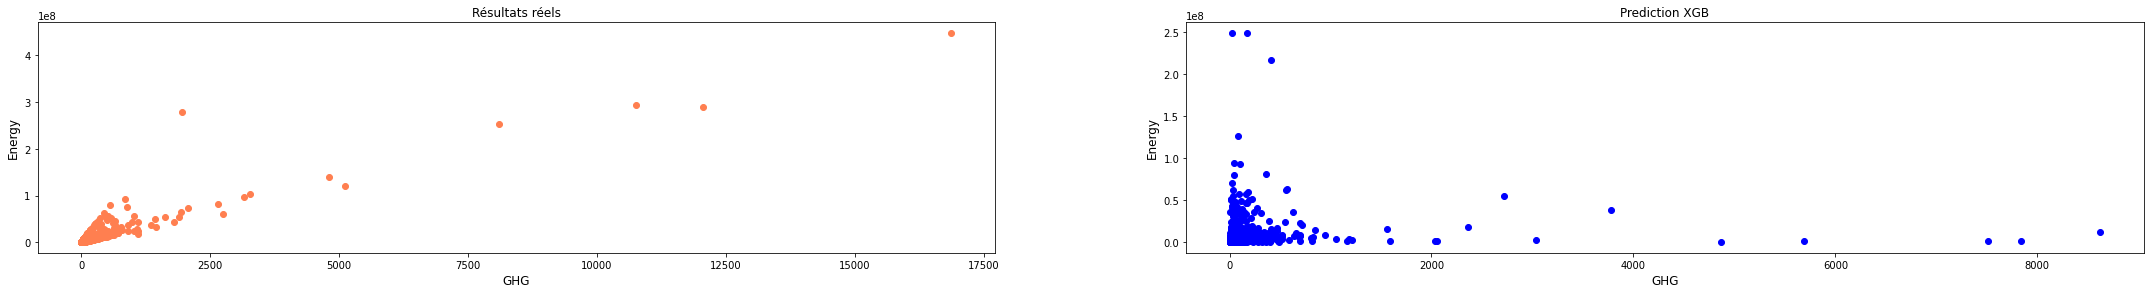

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)
        
ax1.scatter(df_energystar['TotalGHGEmissions_avg'], df_energystar['SiteEnergyUse(kBtu)_avg'], c='coral')
ax1.set_title(f'Résultats réels')
ax1.set_xlabel("GHG", size = 12)
ax1.set_ylabel("Energy", size = 12)
        
ax2.scatter(df_energystar['GHG_predict'], df_energystar['Energy_predict'], c='b')
ax2.set_title(f'Prediction XGB')
ax2.set_xlabel("GHG", size = 12)
ax2.set_ylabel("Energy", size = 12)     

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        

plt.show()